<h1 style="color: 	#80B1D3;"><strong>PAPER LENS PROJECT</strong></h1>

<h2 style="color: 	#365F93;"><strong>Overview</strong></h2>

<h3 style="color: 	#365F93;">🎯 Objective</h3>

This notebook is the second part of the Retraction Risk Prediction project. Having acquired, cleaned, and enriched our dataset in the previous stage, our focus now shifts to **uncovering insights and building a predictive model**.

We will conduct a thorough Exploratory Data Analysis (EDA) to understand the relationships between our features and retraction events. Subsequently, we will perform feature engineering, including the creation of text embeddings from titles, to prepare the data for machine learning. Finally, we will train, evaluate, and compare various classification models to select the one that most accurately and reliably predicts retraction risk.

---

<h3 style="color: 	#365F93;">📦 Steps Covered in This Notebook</h3>

5. **EDA**
6. **Feature Engineering**
7. **Applying Machine Learning Models**
8. **Conclusions**

---

<h3 style="color: 	#365F93;">📁 Dataset</h3>

- **Source**: The final, enriched "Golden Dataset" created in the *01_Data_Acquisition_and_Preparation.ipynb* notebook
- **Format**: `.csv`
- **Records**: ~110k total records, comprising a balanced set of retracted and non-retracted papers.<br><br>
- **Target Variable**:
  - `is_retracted`: A binary flag (1 for retracted, 0 for non-retracted).<br><br>
- **Feature Variables (examples)**:
  - **Bibliographic**: `publication_year`, `article_type`, `is_open_access`, `n_references`.
  - **Authorship**: `author_count`, `country_count`, `first_author_country`, `is_international_collaboration`.
  - **Venue**: `publisher`, `journal_name`.
  - **Content (NLP)**:  `title_length`, `abstract_length`, `n_concepts`, `top_concept_level`.
  - **Impact**: `citations_in_first_2_years`.

---

In [ ]:
# Run in the terminal: pip install -r requirements.txt

In [ ]:
# Install required packages if not already installed throught the requirements.txt
# %pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


In [32]:
# SETUP AND IMPORTS

# Core Libraries
import pandas as pd
import numpy as np
import os
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: Preprocessing & Metrics
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# Machine Learning: Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle


# NLP for Embeddings
# for later for title/abstract analysis: from sentence_transformers import SentenceTransformer

# Environment Settings (Ignore warnings for a cleaner output)
warnings.filterwarnings('ignore')

# Set options for better DataFrame display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Seaborn style for plots
sns.set_style('whitegrid')
sns.set_palette('deep')

In [ ]:
# Importing custom utility functions from the src folder
import os
import sys
sys.path.append('../src')
from x import x

<h2 style="color: 	#365F93;"><strong>5. EDA</strong></h2>

In [2]:
# 1. LOAD THE PREPARED DATASETS

# Define file paths
cases_path = '../data/processed/retracted_cases_final.csv'
controls_path = '../data/processed/non_retracted_controls_final.csv'

# Load the cases (retracted articles)
try:
    df_cases = pd.read_csv(cases_path)
    print(f"✅ Successfully loaded {len(df_cases)} cases from '{cases_path}'")
except FileNotFoundError:
    print(f"❌ ERROR: Cases file not found at '{cases_path}'")
    df_cases = pd.DataFrame()

# Load the controls (non-retracted articles)
try:
    df_controls = pd.read_csv(controls_path)
    print(f"✅ Successfully loaded {len(df_controls)} controls from '{controls_path}'")
except FileNotFoundError:
    print(f"⚠️ WARNING: Controls file not found at '{controls_path}'. Creating an empty DataFrame.")
    print("This is expected if the acquisition process is not complete.")
    df_controls = pd.DataFrame()

✅ Successfully loaded 55682 cases from '../data/processed/retracted_cases_final.csv'
✅ Successfully loaded 51428 controls from '../data/processed/non_retracted_controls_final.csv'


### Creating the Golden Dataset

The next critical step is to combine our `cases` and `controls` into a single, analysis-ready DataFrame. For our first modeling approach, we will prioritize a perfectly balanced dataset.

To achieve this, we will:
1.  Identify all the retracted cases for which a control twin was successfully found.
2.  Filter our main `df_cases` DataFrame to include only these "matched" cases.
3.  Concatenate this filtered set of cases with our complete `df_controls` DataFrame.

This method ensures a precise 1:1 ratio between the two classes (`is_retracted = 1` and `is_retracted = 0`), which is the ideal setup for training and evaluating a robust classification model.

In [3]:
# 2: CREATE THE GOLDEN DATASET FOR ANALYSIS

if not df_cases.empty and not df_controls.empty:
    print("Combining cases and controls into the final 'golden_dataset'.")
    
    # Get the list of DOIs for which we successfully found a control twin
    successful_case_dois = df_controls['original_case_doi'].unique()
    
    # Filter the original cases to only include those that have a matched control
    # This ensures a perfect 1:1 balance in our dataset
    df_cases_matched = df_cases[df_cases['doi'].isin(successful_case_dois)]
    
    print(f"Original cases: {len(df_cases)}")
    print(f"Cases with a found twin: {len(df_cases_matched)}")
    print(f"Controls found: {len(df_controls)}")
    print("Proceeding with a balanced dataset.")
    
    # Concatenate the matched cases and the found controls
    golden_dataset = pd.concat([df_cases_matched, df_controls], ignore_index=True)
    
    # Shuffle the dataset
    golden_dataset = golden_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n✅ Golden dataset created with a total of {len(golden_dataset)} records.")
    
    # Verify the balance of the target variable
    print("\nTarget variable distribution:")
    # Should be exactly 50/50
    print(golden_dataset['is_retracted'].value_counts(normalize=True))
    
    display(golden_dataset.head())
    
else:
    print("Cannot create golden_dataset because one or both of the source DataFrames are empty.")

Combining cases and controls into the final 'golden_dataset'.
Original cases: 55682
Cases with a found twin: 51428
Controls found: 51428
Proceeding with a balanced dataset.

✅ Golden dataset created with a total of 102856 records.

Target variable distribution:
is_retracted
1    0.5
0    0.5
Name: proportion, dtype: float64


,doi,source_id,publication_year,article_type,is_open_access,author_count,institution_count,country_count,first_author_country,is_international_collaboration,journal_name,publisher,is_publisher_missing,title,abstract,title_length,abstract_length,is_abstract_missing,n_concepts,top_concept_level,citations_in_first_2_years,n_references,retraction_nature,reason,is_retracted,match_quality,original_case_doi
0,10.1155/2022/3549510,https://openalex.org/S2764668616,2022,article,True,1,2,2,CN,True,Journal of Mathematics,Hindawi Publishing Corporation,False,Dynamic Alterations and the Affecting Attribut...,This paper employs a method called the populat...,185,1241,False,17,2,1,3,Retraction,+Concerns/Issues About Data;+Concerns/Issues a...,1,NaN,NaN
1,10.3892/mmr.2014.2983,https://openalex.org/S95395365,2014,article,True,6,2,1,CN,False,Molecular Medicine Reports,Spandidos Publishing,False,Blockade of 11β-hydroxysteroid dehydrogenase t...,Osteoarthritis (OA) is a common cause of funct...,115,1395,False,18,3,0,28,Retraction,+Author Unresponsive;+Investigation by Journal...,1,NaN,NaN
2,10.1145/3465631.3465938,NaN,2021,article,False,4,2,1,CN,False,NaN,NaN,True,Innovation of College Physical Education Teach...,NaN,77,0,True,10,2,1,1,Retraction,+Fake Peer Review;+Investigation by Journal/Pu...,1,NaN,NaN
3,10.1093/comjnl/bxr017,https://openalex.org/S44643521,2011,article,False,6,3,2,CN,True,The Computer Journal,Oxford University Press,False,ID Repetition in Structured P2P Networks,Identity (ID) uniqueness is essential in distr...,40,1376,False,28,0,0,0,NaN,NaN,0,Country_Only,10.1109/icebeg.2011.5882709
4,10.3892/etm.2017.4231,https://openalex.org/S151424340,2017,article,True,5,2,1,CN,False,Experimental and Therapeutic Medicine,Spandidos Publishing,False,HOTAIR is a promising novel biomarker in patie...,Thyroid cancer (TC) is the most common endocri...,69,1179,False,17,5,10,24,NaN,NaN,0,Source_and_Country,10.3892/etm.2017.4342


In [4]:
golden_dataset

,doi,source_id,publication_year,article_type,is_open_access,author_count,institution_count,country_count,first_author_country,is_international_collaboration,journal_name,publisher,is_publisher_missing,title,abstract,title_length,abstract_length,is_abstract_missing,n_concepts,top_concept_level,citations_in_first_2_years,n_references,retraction_nature,reason,is_retracted,match_quality,original_case_doi
0,10.1155/2022/3549510,https://openalex.org/S2764668616,2022,article,True,1,2,2,CN,True,Journal of Mathematics,Hindawi Publishing Corporation,False,Dynamic Alterations and the Affecting Attribut...,This paper employs a method called the populat...,185,1241,False,17,2,1,3,Retraction,+Concerns/Issues About Data;+Concerns/Issues a...,1,NaN,NaN
1,10.3892/mmr.2014.2983,https://openalex.org/S95395365,2014,article,True,6,2,1,CN,False,Molecular Medicine Reports,Spandidos Publishing,False,Blockade of 11β-hydroxysteroid dehydrogenase t...,Osteoarthritis (OA) is a common cause of funct...,115,1395,False,18,3,0,28,Retraction,+Author Unresponsive;+Investigation by Journal...,1,NaN,NaN
2,10.1145/3465631.3465938,NaN,2021,article,False,4,2,1,CN,False,NaN,NaN,True,Innovation of College Physical Education Teach...,NaN,77,0,True,10,2,1,1,Retraction,+Fake Peer Review;+Investigation by Journal/Pu...,1,NaN,NaN
3,10.1093/comjnl/bxr017,https://openalex.org/S44643521,2011,article,False,6,3,2,CN,True,The Computer Journal,Oxford University Press,False,ID Repetition in Structured P2P Networks,Identity (ID) uniqueness is essential in distr...,40,1376,False,28,0,0,0,NaN,NaN,0,Country_Only,10.1109/icebeg.2011.5882709
4,10.3892/etm.2017.4231,https://openalex.org/S151424340,2017,article,True,5,2,1,CN,False,Experimental and Therapeutic Medicine,Spandidos Publishing,False,HOTAIR is a promising novel biomarker in patie...,Thyroid cancer (TC) is the most common endocri...,69,1179,False,17,5,10,24,NaN,NaN,0,Source_and_Country,10.3892/etm.2017.4342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102851,10.1109/etcs.2010.13,NaN,2010,article,False,2,1,1,CN,False,NaN,NaN,True,Notice of Retraction: A Study on the Concealed...,NaN,98,0,True,8,2,0,0,Retraction,+Notice - Limited or No Information;,1,NaN,NaN
102852,10.1155/2022/7017610,https://openalex.org/S15444899,2022,article,True,8,3,1,CN,False,Evidence-based Complementary and Alternative M...,Hindawi Publishing Corporation,False,Research on the Mechanism of Liuwei Dihuang De...,Osteoporosis is an important health problem wo...,112,2224,False,9,3,1,107,NaN,NaN,0,Source_and_Country,10.1155/2022/5702014
102853,10.1002/dta.2917,https://openalex.org/S36361591,2020,article,False,2,0,1,US,False,Drug Testing and Analysis,Wiley,False,High‐throughput liquid chromatography tandem m...,"In the recent years, a lot of effort was put i...",136,1593,False,12,1,6,44,NaN,NaN,0,Source_Only,10.1002/dta.2983
102854,10.1073/pnas.0805837105,https://openalex.org/S125754415,2008,article,True,2,2,1,US,False,Proceedings of the National Academy of Sciences,National Academy of Sciences,False,Selection of cyclic peptide aptamers to HCV IR...,The hepatitis C virus (HCV) is a positive stra...,71,1288,False,16,5,0,31,Retraction,+Results Not Reproducible;,1,NaN,NaN


In [5]:
# 3: INITIAL EXPLORATORY DATA ANALYSIS (EDA)

if 'golden_dataset' in locals() and not golden_dataset.empty:
    print("Initial Data Overview")
    golden_dataset.info()
    
    print("Missing Value Analysis")
    # Calculate and display missing values
    missing_values = golden_dataset.isnull().sum()
    missing_percent = (missing_values / len(golden_dataset)) * 100
    missing_table = pd.concat([missing_values, missing_percent], axis=1, keys=['Total Missing', 'Percentage (%)'])
    print(missing_table[missing_table['Total Missing'] > 0].sort_values(by='Percentage (%)', ascending=False))
    
    print("Descriptive Statistics for Numerical Features")
    display(golden_dataset.describe().T)
    
else:
    print("Golden dataset not available for EDA.")

Initial Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102856 entries, 0 to 102855
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   doi                             102856 non-null  object
 1   source_id                       97370 non-null   object
 2   publication_year                102856 non-null  int64 
 3   article_type                    102856 non-null  object
 4   is_open_access                  102856 non-null  bool  
 5   author_count                    102856 non-null  int64 
 6   institution_count               102856 non-null  int64 
 7   country_count                   102856 non-null  int64 
 8   first_author_country            97858 non-null   object
 9   is_international_collaboration  102856 non-null  bool  
 10  journal_name                    97370 non-null   object
 11  publisher                       93984 non-null   object
 12  is_publi

,count,mean,std,min,25%,50%,75%,max
publication_year,102856.0,2016.257846,6.693366,1940.0,2012.0,2018.0,2021.0,2025.0
author_count,102856.0,4.678677,6.622781,0.0,2.0,4.0,6.0,1040.0
institution_count,102856.0,2.167982,2.220782,0.0,1.0,2.0,3.0,104.0
country_count,102856.0,1.297688,0.935539,0.0,1.0,1.0,1.0,39.0
title_length,102856.0,108.061737,38.058164,0.0,83.0,105.0,130.0,500.0
abstract_length,102856.0,985.069797,1559.135342,0.0,0.0,999.0,1554.0,46143.0
n_concepts,102856.0,14.511297,5.234956,1.0,11.0,15.0,18.0,37.0
top_concept_level,102856.0,1.888747,1.307587,0.0,1.0,2.0,3.0,5.0
citations_in_first_2_years,102856.0,3.368642,25.148586,0.0,0.0,1.0,3.0,5108.0
n_references,102856.0,29.685016,27.976810,0.0,12.0,26.0,40.0,2043.0


In [6]:
golden_dataset.columns

Index(['doi', 'source_id', 'publication_year', 'article_type',
       'is_open_access', 'author_count', 'institution_count', 'country_count',
       'first_author_country', 'is_international_collaboration',
       'journal_name', 'publisher', 'is_publisher_missing', 'title',
       'abstract', 'title_length', 'abstract_length', 'is_abstract_missing',
       'n_concepts', 'top_concept_level', 'citations_in_first_2_years',
       'n_references', 'retraction_nature', 'reason', 'is_retracted',
       'match_quality', 'original_case_doi'],
      dtype='object')

<details>
<summary><strong>📘 EDA plan (English)</strong></summary>

<br>

### **Strategic Plan for Exploratory Data Analysis (EDA)**

Now that I have my `golden_dataset` assembled, my goal for the EDA is to **understand the characteristics of my data and start forming hypotheses about which features could be good predictors.** The EDA isn't just about making charts; it's about asking questions of the data.

Here’s the structured plan I'll follow, moving from a general overview to specific details.

#### **Step 1: Univariate Analysis (Analyzing Each Variable Separately)**

The objective here is to understand the distribution of each individual feature.

*   **For Numerical Variables** (like `author_count`, `title_length`, `n_references`, etc.):
    *   **Key Question:** How are these values distributed? Are there extreme outliers?
    *   **Technique:** I'll create **histograms** and **box plots** for each one.
    *   **What I'm Looking For:**
        *   **Skewness:** Do most papers have few citations while a handful have a massive amount? This will show up in histograms as a long tail. It suggests I might need to transform the variable (e.g., with a logarithm) for the model.
        *   **Outliers:** Are there papers with 500 authors or 0 references? Box plots are a great way to visualize this.

*   **For Categorical Variables** (like `is_open_access`, `article_type`, `is_international_collaboration`):
    *   **Key Question:** What is the frequency of each category?
    *   **Technique:** I'll use **bar charts** (`countplot` in Seaborn).
    *   **What I'm Looking For:** Very rare or very dominant categories. This helps me understand the makeup of my dataset.

#### **Step 2: Bivariate Analysis (Analyzing the Relationship Between Two Variables)**

This is where the real insights begin. I'll compare each feature against my target variable, `is_retracted`.

*   **Key Question:** Does this feature behave differently for retracted versus non-retracted papers?

*   **Numerical vs. Target:** (e.g., `author_count` vs. `is_retracted`)
    *   **Technique:**
        *   **Grouped box plots:** One box plot for the `author_count` of non-retracted papers next to one for retracted papers.
        *   **Overlaid histograms (with transparency):** A histogram of `author_count` for each class on the same chart.
    *   **What I'm Looking For:** Is there a visible difference in the medians, distributions, or ranges? If the box for retracted papers is higher or wider, that's a signal.

*   **Categorical vs. Target:** (e.g., `is_open_access` vs. `is_retracted`)
    *   **Technique:** **Grouped or percentage-stacked bar charts.** For example, one bar for "Open Access" showing the percentage of retracted vs. non-retracted, and another bar for "Closed Access."
    *   **What I'm Looking For:** Is the percentage of retracted papers notably higher in one category than another?

#### **Step 3: Correlation Analysis (For Numerical Variables Only)**

*   **Key Question:** Which numerical features are related to each other?
*   **Technique:**
    *   I'll calculate the correlation matrix: `golden_dataset[numerical_features].corr()`.
    *   I'll visualize it with a **heatmap**.
*   **What I'm Looking For:**
    *   **Strong correlations (close to 1 or -1):** For instance, it's likely that `author_count` and `institution_count` are highly correlated. This is called **multicollinearity**. It isn't a major issue for models like XGBoost, but it's good to be aware of.
    *   **Correlations with the target:** While Pearson correlation isn't the best metric for a binary target, it can give me a first hint.

#### **Step 4: Formulating Hypotheses and Summarizing**

After each set of plots, I'll write down my observations in a Markdown cell. For example:
> "I'm observing that the distribution of `citations_in_first_2_years` is highly skewed. Furthermore, the median number of citations for non-retracted papers appears to be slightly higher than for retracted ones. This suggests this feature could have predictive power."

This iterative process of **visualize -> interpret -> document** is the core of a good EDA. It will prepare me perfectly for the Feature Engineering and Modeling phases.

</details>

<details>
<summary><strong>📘 Plan para hacer el EDA (Español)</strong></summary>

<br>

### **Plan Estratégico para el EDA**

Ahora que ya tengo mi `golden_dataset` listo, el objetivo del EDA es **entender las características de mis datos y empezar a formular hipótesis sobre qué features podrían ser buenos predictores.** El EDA no va solo de hacer gráficos, sino de hacerle preguntas a los datos.

Este es el plan estructurado que voy a seguir, yendo de lo general a lo específico.

#### **Paso 1: Análisis Univariado (Analizar cada variable por separado)**

Mi objetivo aquí es entender la distribución de cada una de mis features.

*   **Para las Variables Numéricas** (como `author_count`, `title_length`, `n_references`, etc.):
    *   **Pregunta clave:** ¿Cómo se distribuyen estos valores? ¿Hay valores atípicos (outliers) extremos?
    *   **Técnica:** Voy a crear **histogramas** y **box plots** para cada una.
    *   **Qué voy a buscar:**
        *   **Asimetría (Skewness):** ¿La mayoría de los artículos tienen pocas citas y unos pocos tienen muchísimas? Esto lo veré en histogramas con una "cola" muy larga. Me sugiere que quizás necesite transformar la variable (por ejemplo, con un logaritmo) para el modelo.
        *   **Outliers:** ¿Hay artículos con 500 autores o con 0 referencias? Los box plots son geniales para visualizar esto.

*   **Para las Variables Categóricas** (como `is_open_access`, `article_type`, `is_international_collaboration`):
    *   **Pregunta clave:** ¿Cuál es la frecuencia de cada categoría?
    *   **Técnica:** Usaré **gráficos de barras** (`countplot` en Seaborn).
    *   **Qué voy a buscar:** Categorías muy raras o muy dominantes. Esto me ayudará a entender la composición de mi dataset.

#### **Paso 2: Análisis Bivariado (Analizar la relación entre dos variables)**

Aquí es donde empieza lo interesante. Compararé cada feature con mi variable objetivo, `is_retracted`.

*   **Pregunta clave:** ¿Se comporta esta feature de manera diferente para los artículos retractados y los no retractados?

*   **Numérica vs. Objetivo:** (ej. `author_count` vs. `is_retracted`)
    *   **Técnica:**
        *   **Box plots agrupados:** Un box plot para el `author_count` de los no retractados al lado de otro para los retractados.
        *   **Histogramas superpuestos (con transparencia):** Un histograma de `author_count` para cada clase, en el mismo gráfico.
    *   **Qué voy a buscar:** ¿Hay una diferencia visible en las medianas, las distribuciones o los rangos? Si el box plot de los retractados está más arriba o es más ancho, ¡esa es una señal!

*   **Categórica vs. Objetivo:** (ej. `is_open_access` vs. `is_retracted`)
    *   **Técnica:** **Gráficos de barras agrupados o apilados porcentualmente.** Por ejemplo, una barra para "Open Access" que muestre el porcentaje de retractados vs. no retractados, y otra barra igual para "Closed Access".
    *   **Qué voy a buscar:** ¿El porcentaje de retractados es notablemente mayor en una categoría que en otra?

#### **Paso 3: Análisis de Correlación (Solo para variables numéricas)**

*   **Pregunta clave:** ¿Qué features numéricas están relacionadas entre sí?
*   **Técnica:**
    *   Calcularé la matriz de correlación: `golden_dataset[numerical_features].corr()`.
    *   La visualizaré con un **mapa de calor (heatmap)**.
*   **Qué voy a buscar:**
    *   **Correlaciones fuertes (cercanas a 1 o -1):** Por ejemplo, es probable que `author_count` e `institution_count` estén altamente correlacionadas. Esto se llama **multicolinealidad**. No es un problema grave para modelos como XGBoost, pero es bueno tenerlo localizado.
    *   **Correlaciones con el objetivo:** Aunque la correlación de Pearson no es la mejor medida para una variable binaria, me puede dar una primera pista.

#### **Paso 4: Formular Hipótesis y Resumir**

Después de cada grupo de gráficos, escribiré en una celda de Markdown lo que he observado. Por ejemplo:
> "Estoy observando que la distribución de `citations_in_first_2_years` es muy asimétrica. Además, la mediana de citas para los artículos no retractados parece ser ligeramente superior a la de los retractados. Esto me sugiere que esta feature podría tener poder predictivo."

Este proceso iterativo de **visualizar -> interpretar -> documentar** es la clave de un buen EDA y me preparará perfectamente para la fase de Feature Engineering y modelado.

</details>

In [ ]:
# Identify Feature Types for EDA

# Define columns that are neither numerical nor standard categorical for this specific EDA phase
# These are identifiers, free text, or metadata we won't plot directly here
cols_to_exclude_from_plots = [
    'doi', 'source_id', 'title', 'abstract', 'journal_name', 'publisher', 
    'first_author_country', 'reason', 'retraction_nature', 'original_case_doi', 'match_quality'
]

# Identify numerical features
numerical_features = golden_dataset.select_dtypes(include=np.number).columns.tolist()
# Remove the target variable and year from this list for now
numerical_features.remove('is_retracted')
numerical_features.remove('publication_year') 

# Identify categorical/boolean features
categorical_features = golden_dataset.select_dtypes(include=['object', 'boolean']).columns.tolist()
# And remove the ones we decided to exclude from direct plotting
categorical_features = [col for col in categorical_features if col not in cols_to_exclude_from_plots]

print("EDA Feature Lists")
print(f"\nNumerical features to analyze:\n{numerical_features}")
print(f"\nCategorical features to analyze:\n{categorical_features}")

EDA Feature Lists

Numerical features to analyze:
['author_count', 'institution_count', 'country_count', 'title_length', 'abstract_length', 'n_concepts', 'top_concept_level', 'citations_in_first_2_years', 'n_references']

Categorical features to analyze:
['article_type', 'is_open_access', 'is_international_collaboration', 'is_publisher_missing', 'is_abstract_missing']


Plotting Numerical Feature Distributions


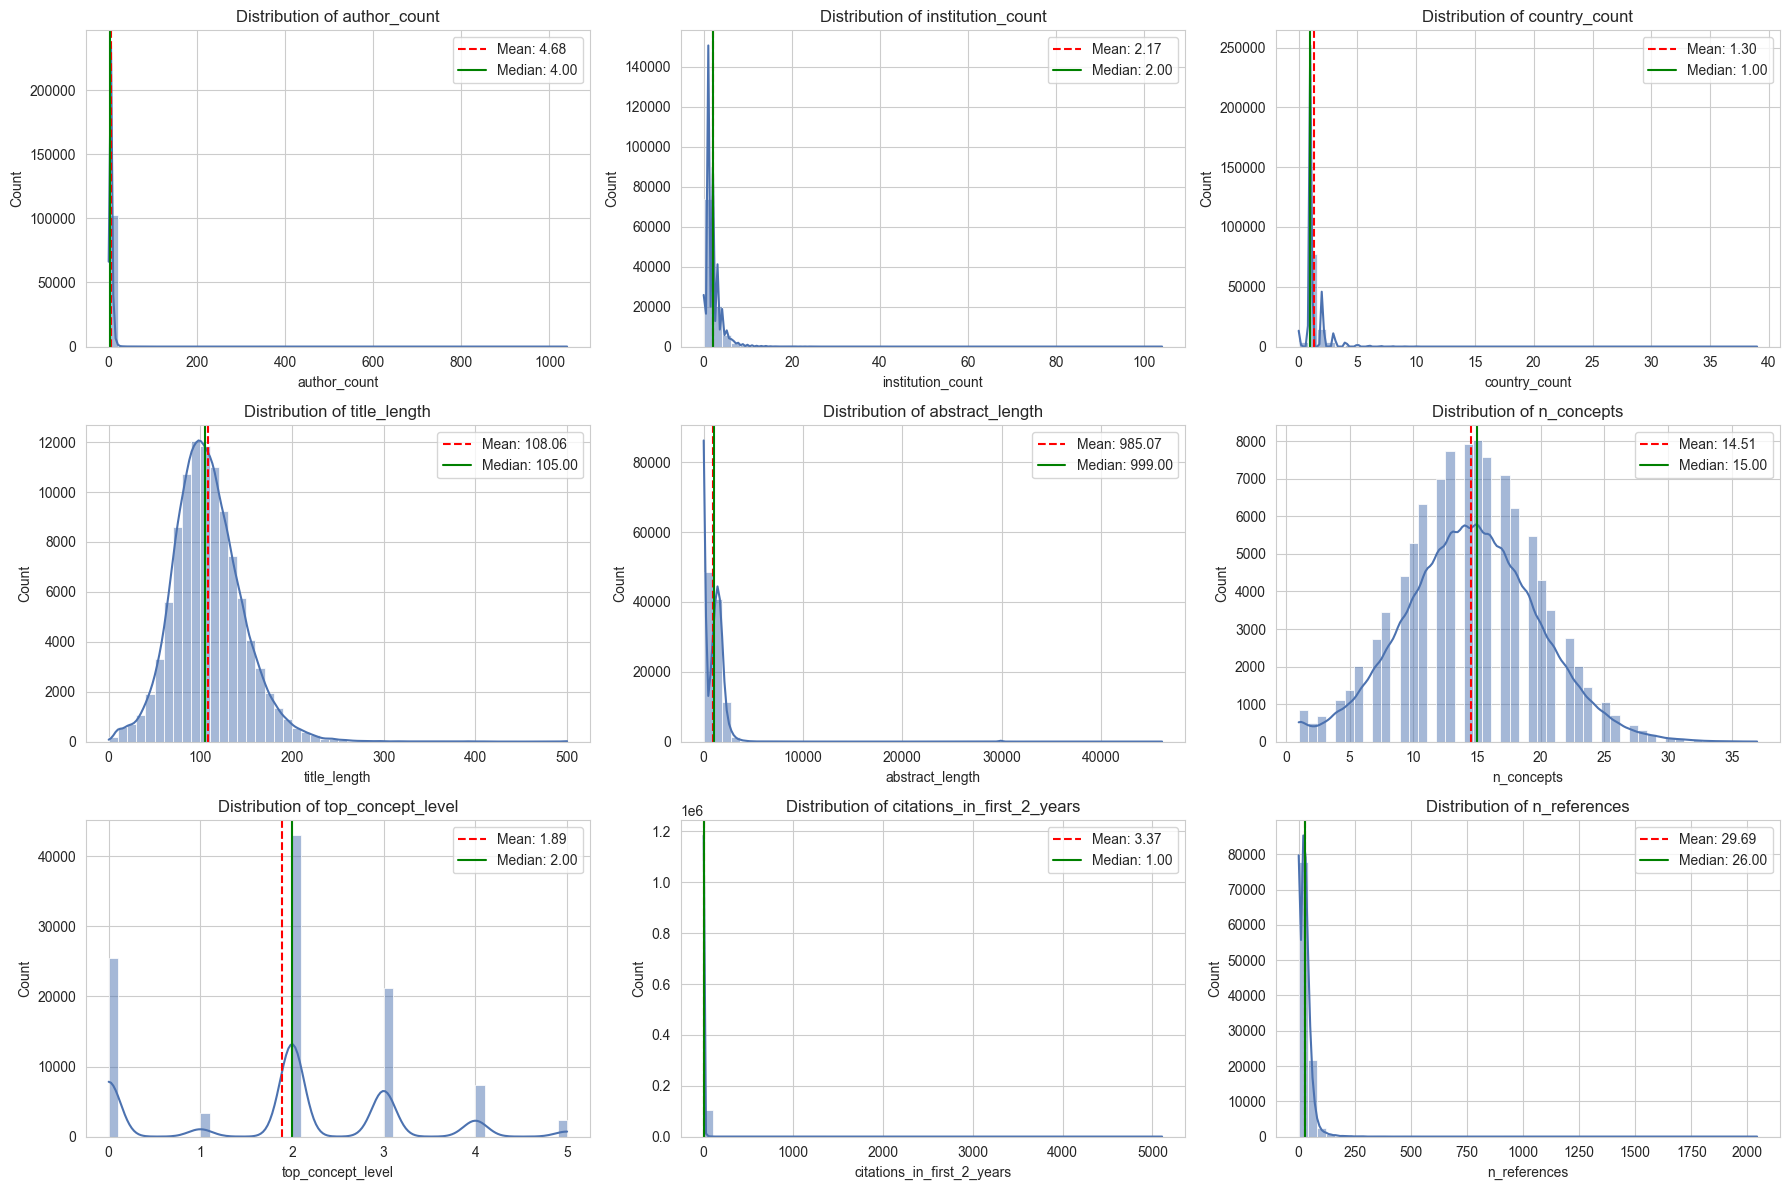

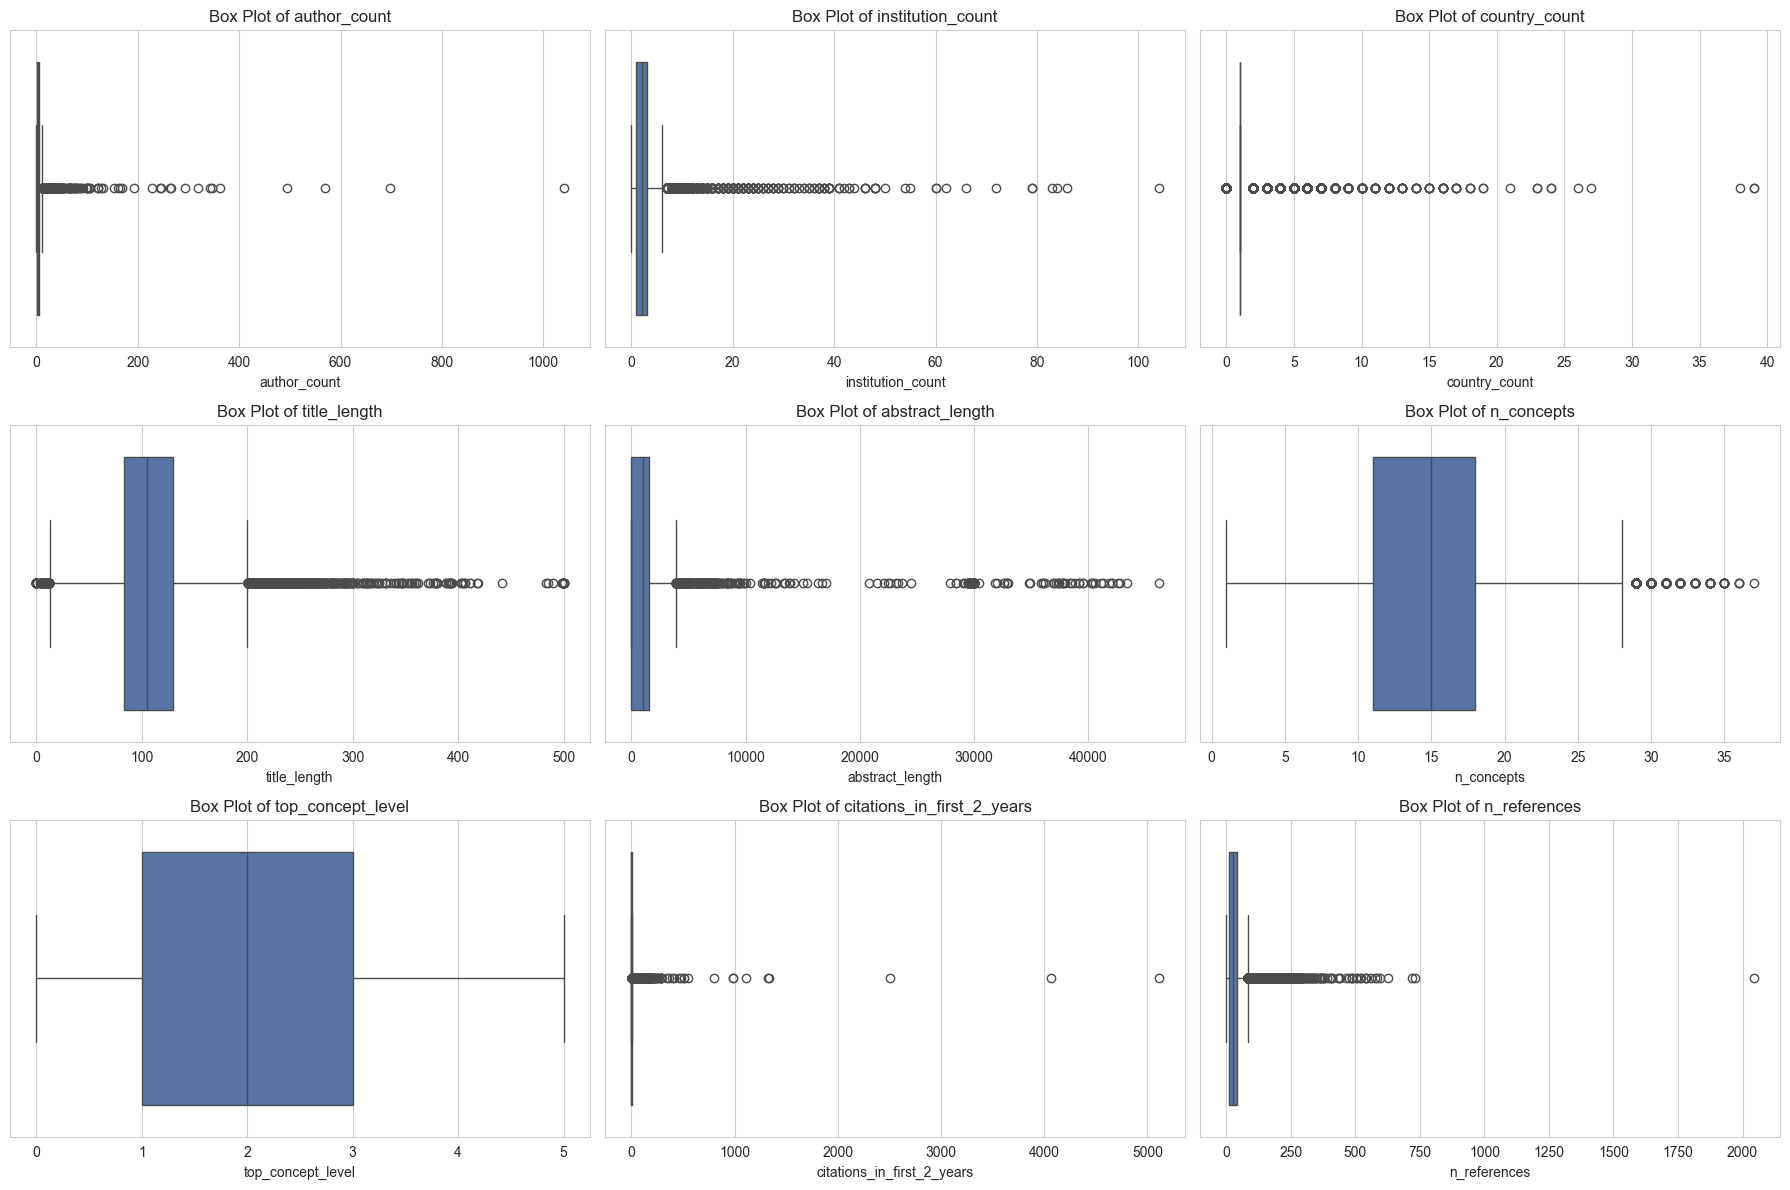

In [ ]:
# Univariate Analysis of Numerical Features

print("Plotting Numerical Feature Distributions")

# Determine the grid size for the plots
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols # Ceiling division

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, feature in enumerate(numerical_features):
    # Plot Histogram
    sns.histplot(data=golden_dataset, x=feature, ax=axes[i], kde=True, bins=50)
    
    # Calculate median and mean to add to the plot
    mean_val = golden_dataset[feature].mean()
    median_val = golden_dataset[feature].median()
    
    # Add vertical lines for mean and median
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Box Plots for the same features to see outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=golden_dataset, x=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}', fontsize=12)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Plotting Categorical Feature Distributions


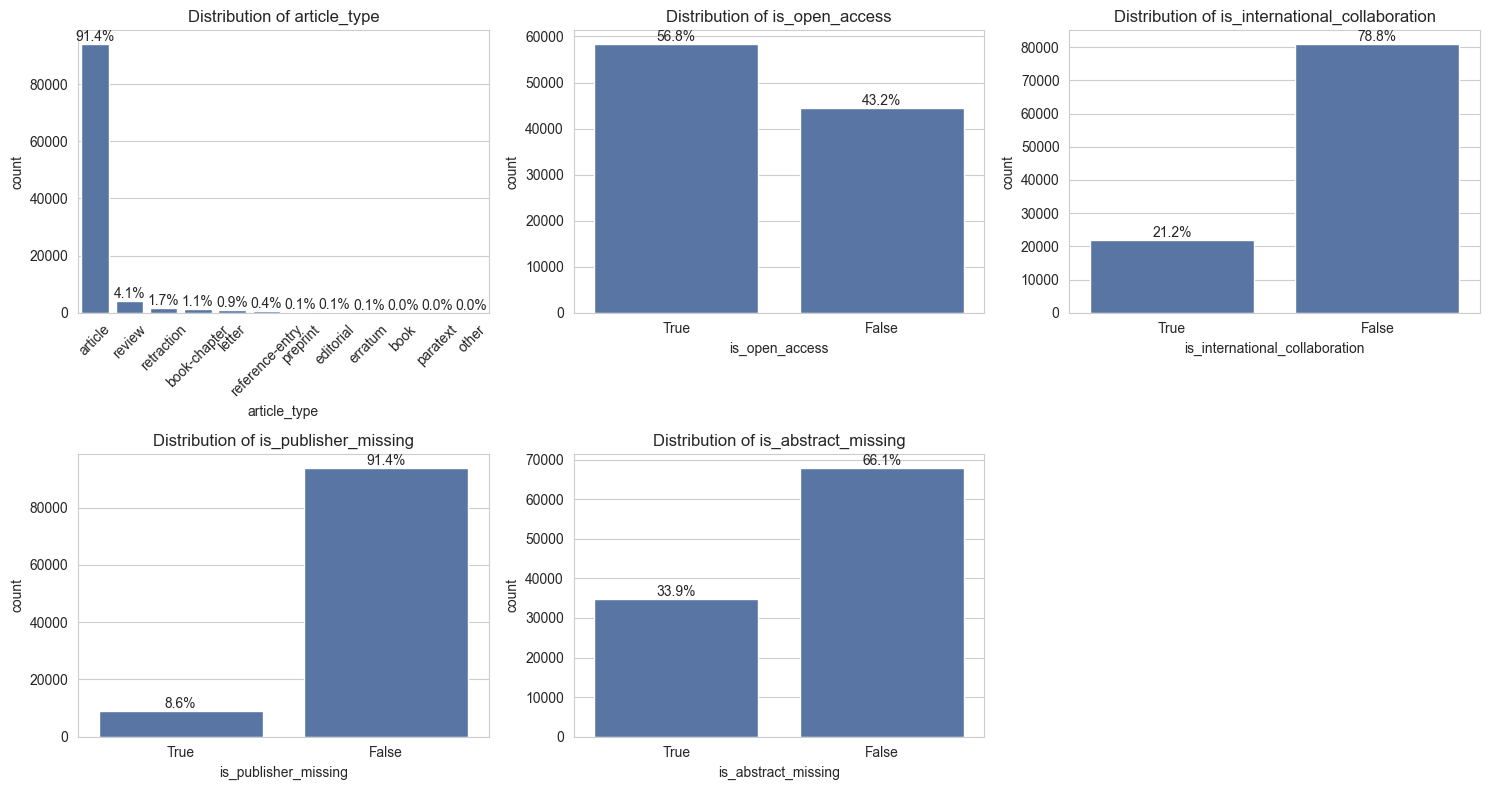

In [ ]:
# Univariate Analysis of Categorical Features

print("Plotting Categorical Feature Distributions")

# We use the 'categorical_features' list we created earlier
# ['article_type', 'is_open_access', 'is_international_collaboration', 
#  'is_publisher_missing', 'is_abstract_missing']

# Determine grid size
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # For boolean features, we can make the labels more explicit
    if golden_dataset[feature].dtype == 'bool':
        # Create a temporary series with string labels for plotting
        plot_data = golden_dataset[feature].map({True: 'True', False: 'False'})
        sns.countplot(x=plot_data, ax=axes[i], order=['True', 'False'])
    else:
        # For other object/categorical types
        sns.countplot(data=golden_dataset, x=feature, ax=axes[i], order=golden_dataset[feature].value_counts().index)
    
    # Add percentage labels on top of the bars
    total = len(golden_dataset[feature])
    for p in axes[i].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(percentage, (x, y), ha='center', va='bottom')
        
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    # Rotate x-axis labels if they are long
    if len(golden_dataset[feature].unique()) > 4:
        axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Plotting Numerical Features against Target (is_retracted)


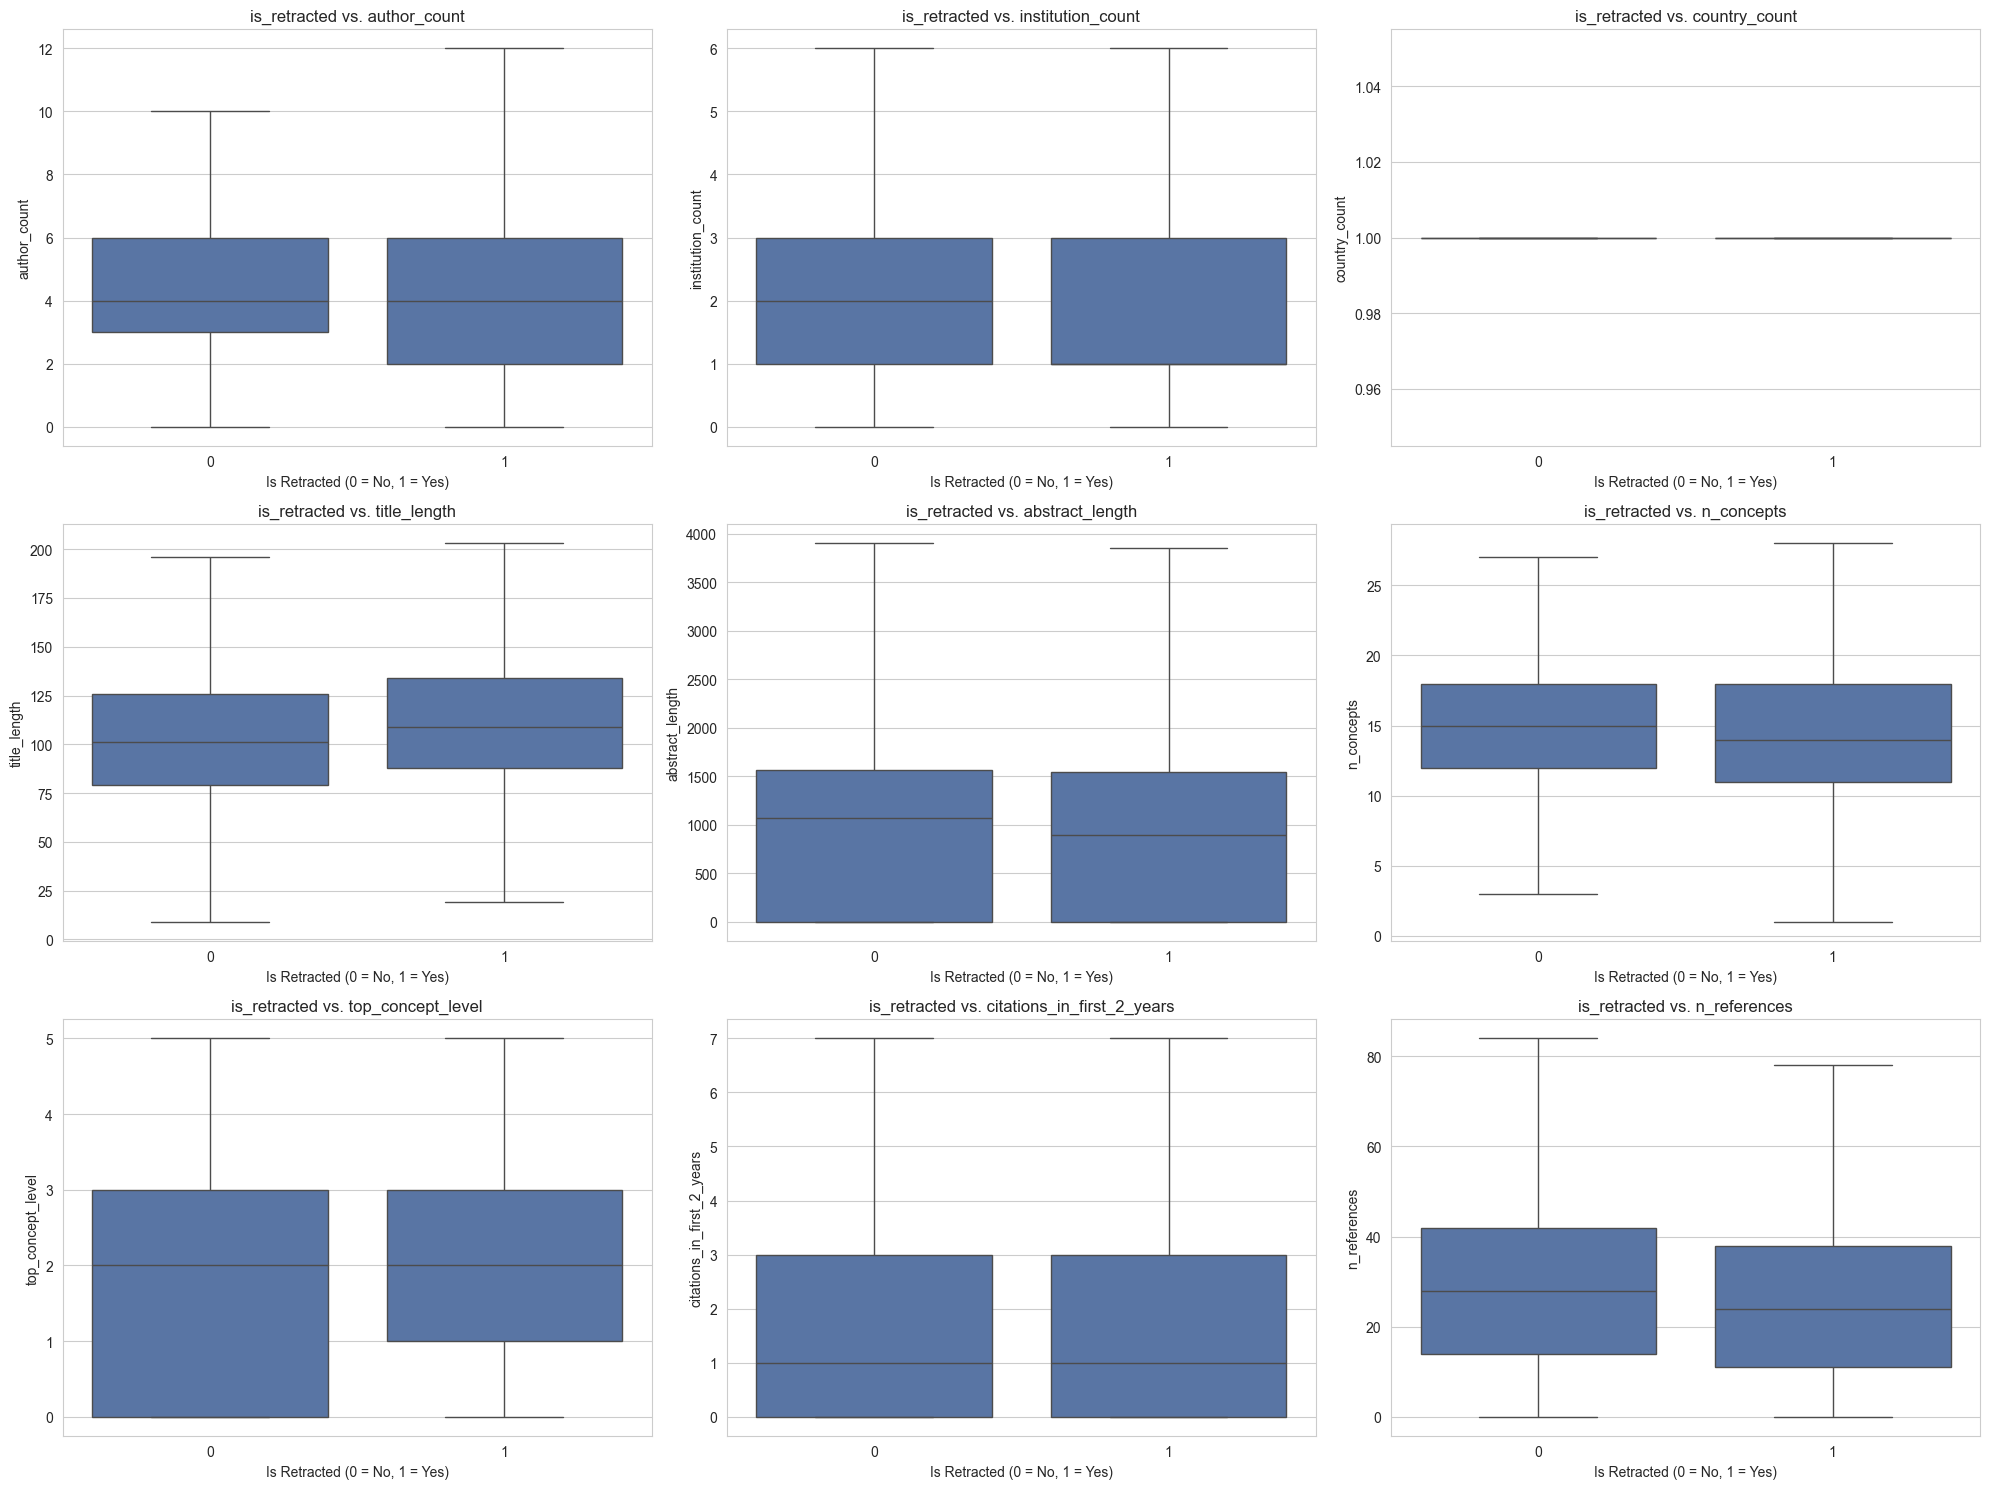

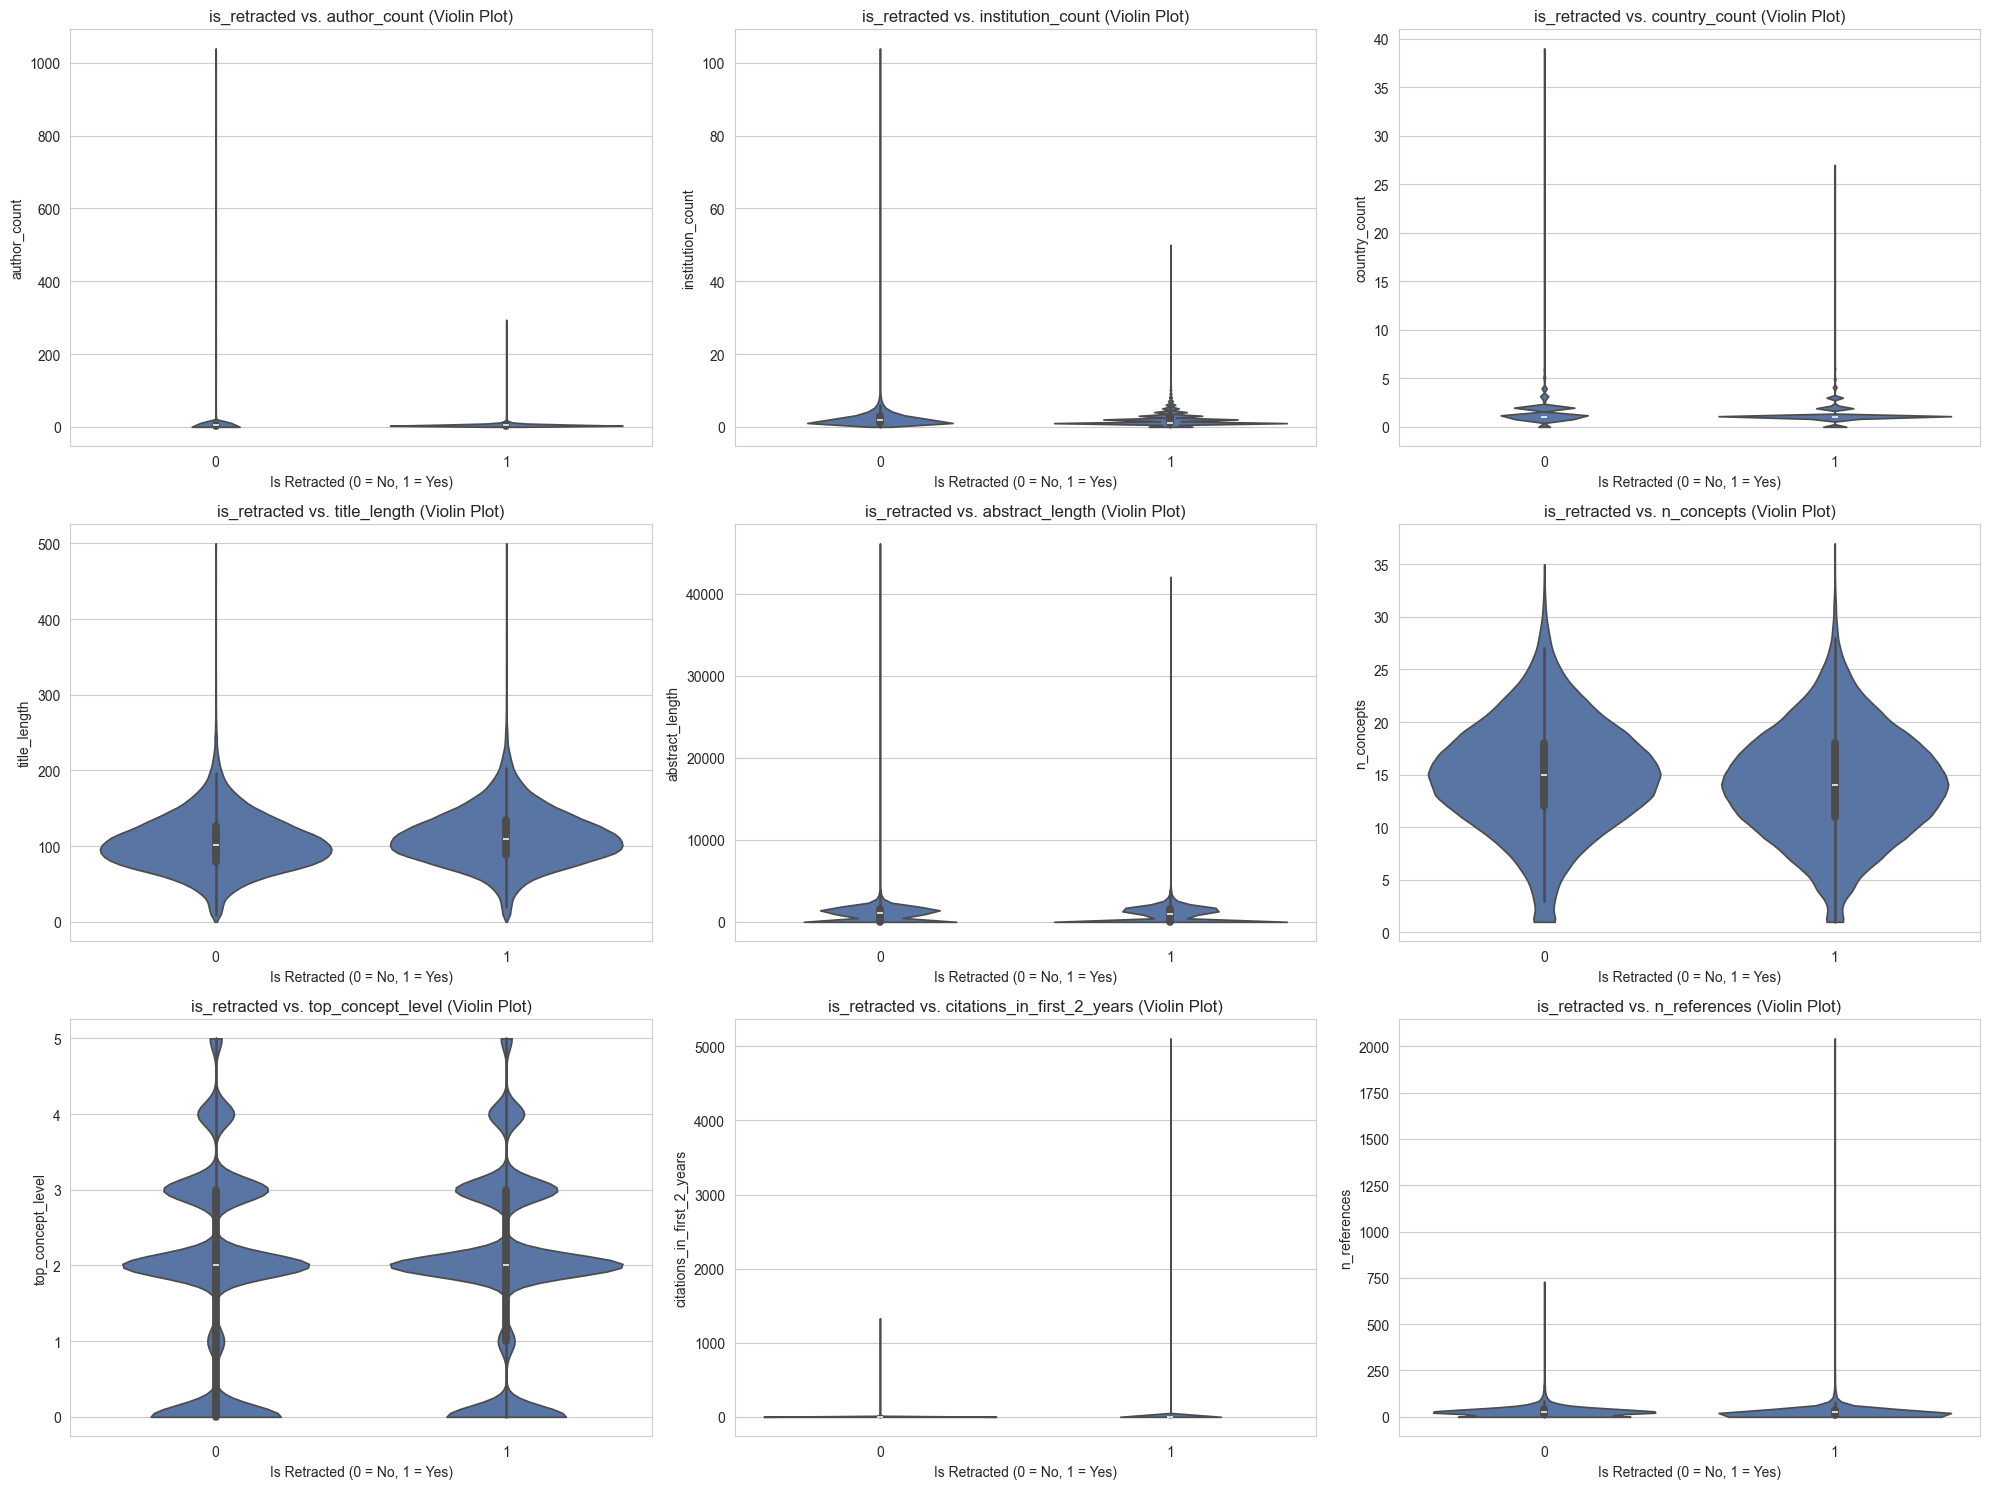

In [ ]:
# Bivariate Analysis - Numerical Features vs. Target

print("Plotting Numerical Features against Target (is_retracted)")

# We use the 'numerical_features' list we defined earlier
# ['author_count', 'institution_count', 'country_count', 'title_length', ...]

# Determine grid size for the plots
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=golden_dataset, x='is_retracted', y=feature, ax=axes[i], showfliers=False)
    # We set showfliers=False to focus on the distribution of the 'boxes' (the central 50% of data).
    # The outliers make the boxes too small to compare otherwise.
    
    axes[i].set_title(f'is_retracted vs. {feature}', fontsize=12)
    axes[i].set_xlabel("Is Retracted (0 = No, 1 = Yes)")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Optional: A more detailed view with Violin Plots
# Violin plots are like box plots but also show the probability density of the data.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.violinplot(data=golden_dataset, x='is_retracted', y=feature, ax=axes[i], cut=0)
    # cut=0 prevents the violin from extending beyond the data range.
    
    axes[i].set_title(f'is_retracted vs. {feature} (Violin Plot)', fontsize=12)
    axes[i].set_xlabel("Is Retracted (0 = No, 1 = Yes)")
    
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Plotting Categorical Features against Target (is_retracted)


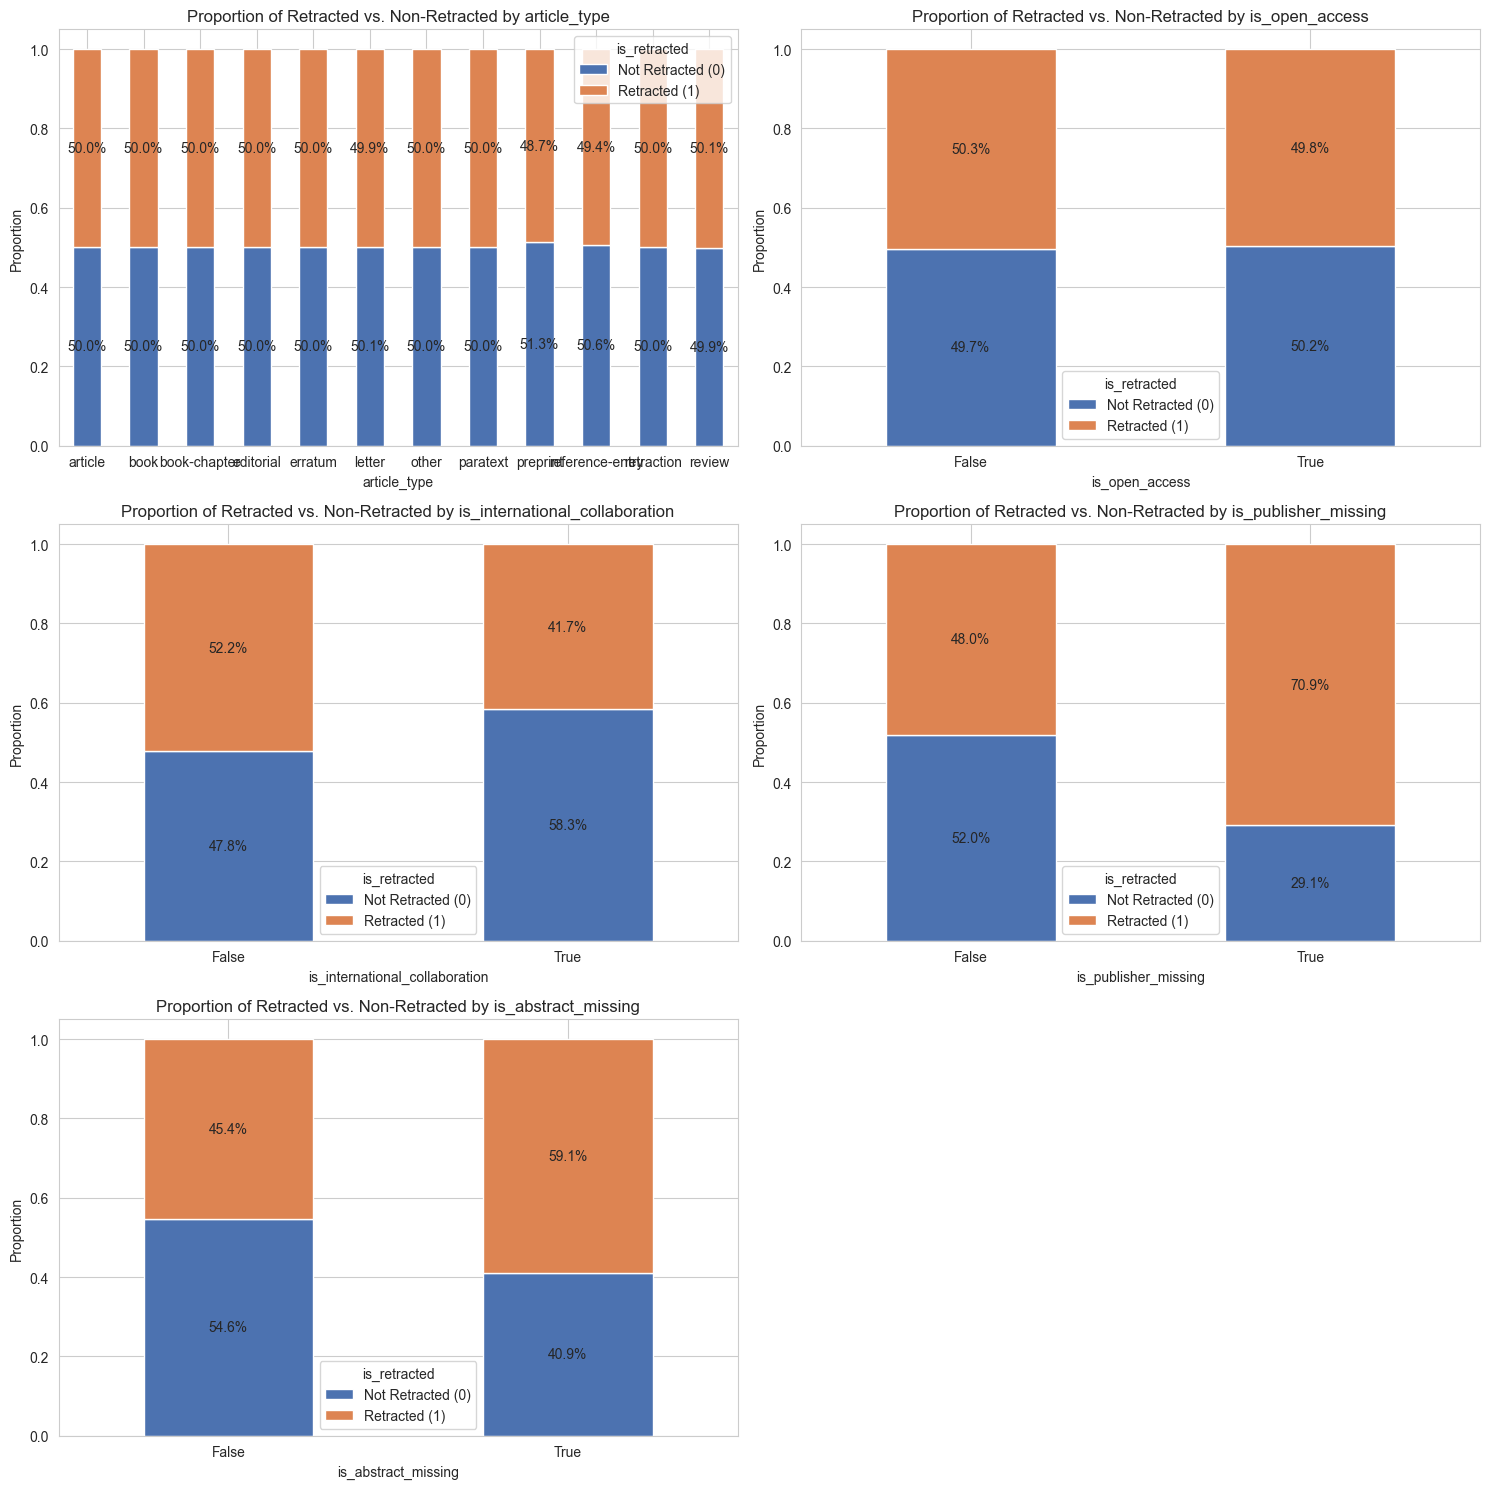

In [11]:
# Bivariate Analysis - Categorical Features vs. Target

print("Plotting Categorical Features against Target (is_retracted)")

# We use the 'categorical_features' list we defined earlier
# ['article_type', 'is_open_access', 'is_international_collaboration', 
#  'is_publisher_missing', 'is_abstract_missing']

# Determine grid size
n_features = len(categorical_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # Calculate the percentage for the plot labels
    # We group by the feature and then get the value counts of 'is_retracted' as a percentage
    props = golden_dataset.groupby(feature)['is_retracted'].value_counts(normalize=True).unstack()
    
    # Plot a stacked bar chart of the proportions
    props.plot(kind='bar', stacked=True, ax=axes[i], rot=0)
    
    axes[i].set_title(f'Proportion of Retracted vs. Non-Retracted by {feature}', fontsize=12)
    axes[i].set_ylabel('Proportion')
    # Improve legend
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, ['Not Retracted (0)', 'Retracted (1)'], title='is_retracted')

    # Add percentage text on each part of the stacked bar
    for bar in axes[i].patches:
        # The width of the bar
        width = bar.get_width()
        # The y position of the bar
        y = bar.get_y()
        # The height of the bar
        height = bar.get_height()
        # The x position of the text
        x = bar.get_x() + width / 2
        
        # Only add text if the height is significant
        if height > 0.01:
            axes[i].text(x, y + height / 2, f'{height:.1%}', ha='center', va='center')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Calculating and Plotting Correlation Matrix


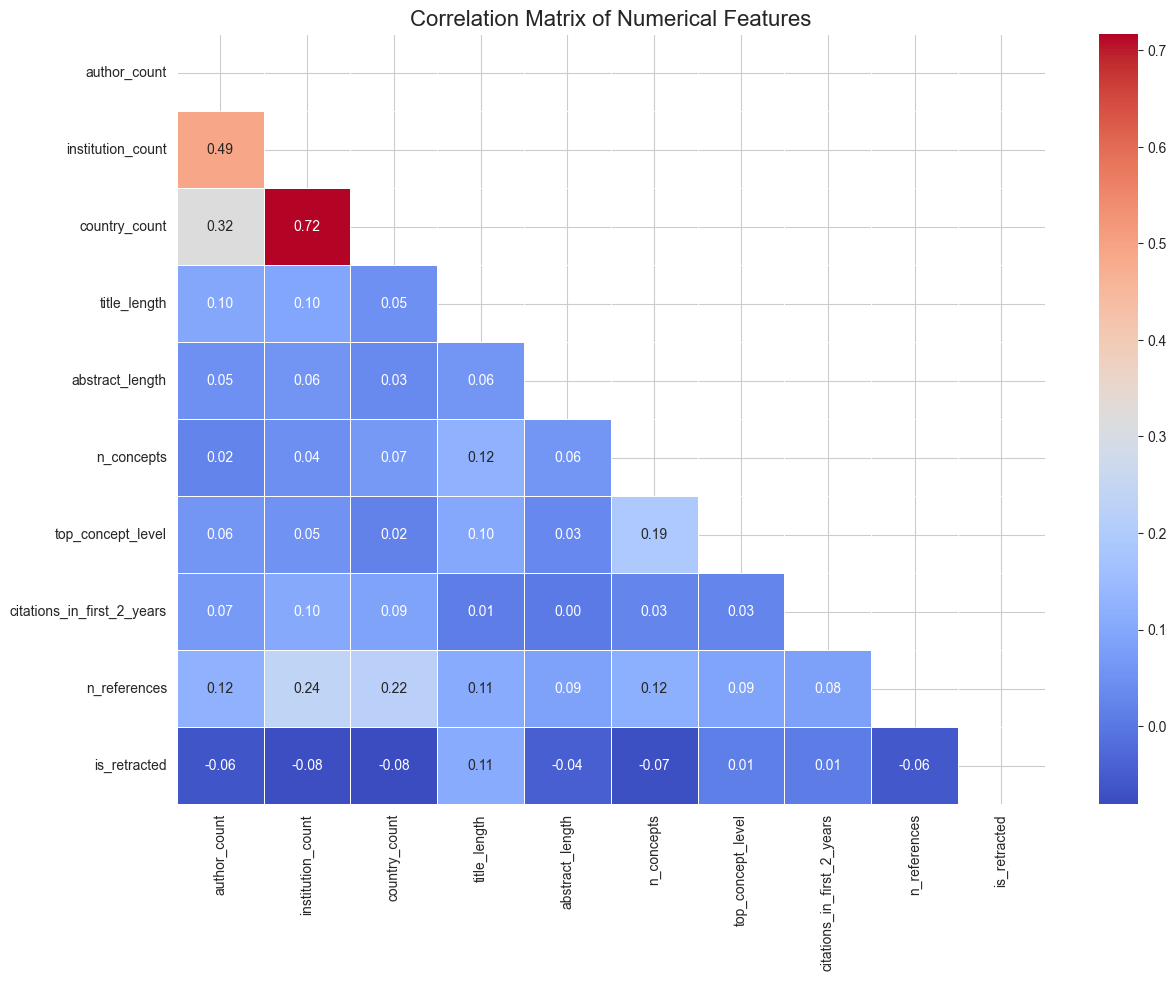


Correlation with Target Variable (is_retracted)
is_retracted                  1.000000
title_length                  0.108745
top_concept_level             0.013584
citations_in_first_2_years    0.009007
abstract_length              -0.043649
n_references                 -0.056337
author_count                 -0.062455
n_concepts                   -0.073007
institution_count            -0.076394
country_count                -0.080904
Name: is_retracted, dtype: float64


In [12]:
# Correlation Analysis

print("Calculating and Plotting Correlation Matrix")

# We want to include our target variable in the correlation analysis
# So we'll use the original numerical_features list and add 'is_retracted'
cols_for_corr = numerical_features + ['is_retracted']

# Calculate the correlation matrix
correlation_matrix = golden_dataset[cols_for_corr].corr()

# Create a mask to hide the upper triangle of the heatmap (as it's a mirror image)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Draw the heatmap
sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap='coolwarm', # A diverging colormap is good for correlations
    annot=True,      # Show the correlation values on the map
    fmt=".2f",       # Format the numbers to two decimal places
    linewidths=.5
)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

# Display the correlations with the target variable specifically
print("\nCorrelation with Target Variable (is_retracted)")
corr_with_target = correlation_matrix['is_retracted'].sort_values(ascending=False)
print(corr_with_target)

### **Exploratory Data Analysis (EDA): Key Findings and Insights**

After preparing and balancing our "golden dataset," we conducted a thorough EDA to understand the underlying patterns and formulate hypotheses about what features might predict paper retraction. The analysis was broken down into three phases: univariate, bivariate, and correlation analysis.

#### **1. Univariate Analysis: Understanding Individual Features**

This initial phase was about getting a feel for the "personality" of each variable.

**Key Observations from Numerical Features:**

*   **Heavily Skewed Distributions:** A significant group of our numerical features—specifically `author_count`, `institution_count`, `country_count`, `abstract_length`, `citations_in_first_2_years`, and `n_references`—exhibit a strong positive skew (right-skewed). The histograms showed that the vast majority of papers have low-to-moderate values for these features, with a long tail of extreme outliers. For instance, while the median number of citations is just 1, the mean is pulled up to 3.37 by a few superstar papers.
*   **"Well-Behaved" Distributions:** In contrast, `n_concepts` displays a nearly perfect normal distribution, and `title_length` is also fairly symmetrical. This tells us these features are quite predictable and their mean and median are close, representing the data well.
*   **Ordinal Nature:** The `top_concept_level` feature, while numeric, behaves like a discrete, ordinal variable, with most papers falling into levels 0 and 2.

**Key Observations from Categorical Features:**

*   **Dominance of "Articles":** Our dataset is overwhelmingly composed of standard `articles` (91.4%), meaning our model will become an expert on this type but less reliable for others like `reviews` or `book-chapters`.
*   **Balanced and Unbalanced Booleans:** The `is_open_access` feature is nicely balanced (57% True vs. 43% False), making it a fair candidate for analysis. Conversely, most papers are *not* international collaborations (78.8% False), and a surprising one-third are missing an abstract (`is_abstract_missing` is 33.9% True). A small but notable 8.6% are also missing a publisher.

**Hypothesis & Next Steps:** The extreme skew in many numerical features strongly suggests that a logarithmic transformation (e.g., `log(x+1)`) during feature engineering could be highly beneficial to help our models better handle the outliers and learn the underlying patterns.

#### **2. Bivariate Analysis: Uncovering the Signals**

This is where we started hunting for predictive signals by comparing each feature against our `is_retracted` target.

**Numerical vs. Target Insights:**

*   **Strong Signals Found:** The most promising indicators were `citations_in_first_2_years` and `n_references`. The box plots clearly showed that the median number of citations and references for non-retracted papers (class 0) is visibly higher than for retracted papers (class 1). This supports the strong hypothesis that retracted papers tend to be less cited and have a poorer literature review foundation.
*   **A Weak Signal:** We found a subtle but consistent pattern with `title_length`. The median length of titles for retracted papers is slightly longer than for non-retracted ones. It’s not a dramatic difference, but it’s a potential signal the model could pick up on.
*   **No Apparent Signal:** Features like `author_count`, `institution_count`, and `n_concepts` showed almost identical distributions for both retracted and non-retracted papers. This was an interesting finding, suggesting that the "typical" number of authors or concepts isn't a straightforward indicator of risk.

**Categorical vs. Target Insights:**

*   **The Smoking Guns:** The most dramatic findings came from our boolean flags. When a publisher is missing (`is_publisher_missing` = True), the retraction rate skyrockets to **70.9%** (compared to 48.0% when a publisher is present). Similarly, when an abstract is missing (`is_abstract_missing` = True), the retraction rate jumps to **59.1%** (from 45.4%). These features are incredibly strong predictors of risk, likely acting as proxies for low-quality or poorly indexed sources.
*   **A Protective Factor:** Being an `is_international_collaboration` appears to be a protective factor. The retraction rate for international papers is only **41.7%**, compared to **52.2%** for non-international ones. This suggests that more "eyes" on a project from different institutions may increase its robustness.
*   **A Non-Factor:** `is_open_access` showed almost no difference in retraction rates between its categories, a surprising result that refutes the simple hypothesis that open-access models are inherently riskier.

#### **3. Correlation Analysis: Inter-Feature Relationships**

The final step was to check for multicollinearity among our numerical features.

*   **High Correlation Identified:** We confirmed a strong positive correlation between `institution_count` and `country_count` (0.72), and a moderate one between them and `author_count`. This is logical, as more authors often come from more institutions, which in turn are more likely to be in different countries. For the tree-based models we plan to use (like XGBoost), this multicollinearity is not a major issue and doesn't require us to remove features at this stage.
*   **Target Correlation Confirms Visuals:** The direct correlation values with `is_retracted` numerically confirmed our bivariate findings: `title_length` has the highest (albeit weak) positive correlation, while the authorship/collaboration features have a slight negative correlation.

#### **Overall EDA Conclusion**

Our exploratory analysis has been highly successful. We have moved from raw data to a set of clear, actionable insights. We've identified our most promising predictive features (`is_publisher_missing`, `is_abstract_missing`, `is_international_collaboration`, `n_references`, `citations_in_first_2_years`) and understand the nature of our data's distributions and outliers.

This provides a solid foundation for the next steps: **Feature Engineering** (e.g., applying log transforms) and **Model Building**.

<h2 style="color: 	#365F93;"><strong>6. Feature Engineering</strong></h2>

In [15]:
# PREPARE DATA FOR MACHINE LEARNING (FEATURE & TARGET SPLIT)

if 'golden_dataset' in locals() and not golden_dataset.empty:
    print("Preparing data for machine learning...")

    # 1. Define the target variable (y)
    target = 'is_retracted'
    y = golden_dataset[target]

    # 2. Define columns to drop. These are either identifiers, text fields for later use, or variables that would cause data leakage or are metadata from our process.
    columns_to_drop = [
        'is_retracted',          # Target variable
        'doi',                   # Identifier
        'source_id',             # Identifier
        'title',                 # Text field for NLP
        'abstract',              # Text field for NLP
        'journal_name',          # High cardinality categorical
        'publisher',             # High cardinality categorical
        'first_author_country',  # High cardinality categorical
        'reason',                # DATA LEAKAGE - only exists for retracted cases
        'retraction_nature',     # DATA LEAKAGE
        'match_quality',         # Process metadata
        'original_case_doi'      # Process metadata
    ]

    # 3. Create the feature matrix (X)
    X = golden_dataset.drop(columns=columns_to_drop)

    print("✅ Feature matrix (X) and target vector (y) have been created.")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    
    # Display the first few rows of the feature matrix to verify
    display(X.head())

else:
    print("Golden dataset not available for ML preparation.")

Preparing data for machine learning...
✅ Feature matrix (X) and target vector (y) have been created.
Shape of X: (102856, 15)
Shape of y: (102856,)


,publication_year,article_type,is_open_access,author_count,institution_count,country_count,is_international_collaboration,is_publisher_missing,title_length,abstract_length,is_abstract_missing,n_concepts,top_concept_level,citations_in_first_2_years,n_references
0,2022,article,True,1,2,2,True,False,185,1241,False,17,2,1,3
1,2014,article,True,6,2,1,False,False,115,1395,False,18,3,0,28
2,2021,article,False,4,2,1,False,True,77,0,True,10,2,1,1
3,2011,article,False,6,3,2,True,False,40,1376,False,28,0,0,0
4,2017,article,True,5,2,1,False,False,69,1179,False,17,5,10,24


In [16]:
# FEATURE ENGINEERING

if 'X' in locals():
    print("Starting Feature Engineering")
    
    # 1. Logarithmic Transformation for Skewed Numerical Features
    # Based on our EDA, these features had a strong positive skew. We apply a log(1+x)
    # transformation to make their distributions more symmetrical and reduce the impact of outliers.
    
    skewed_features = [
        'author_count', 
        'institution_count', 
        'country_count', 
        'abstract_length', 
        'citations_in_first_2_years', 
        'n_references'
    ]
    
    print("Applying log transformation to the following skewed features:")
    print(skewed_features)
    
    for feature in skewed_features:
        # Create a new column with the transformed data
        X[f'{feature}_log'] = np.log1p(X[feature])
        # We keep the original column for now, but will use the transformed one for modeling.

    # 2. Creating Interaction Features as an Experiment
    # These new features might capture relationships that individual features cannot.
    
    # Add a small constant (epsilon) to the denominator to avoid division by zero errors.
    epsilon = 1e-6 
    
    # Feature 1: References per Author
    # Hypothesis: A high number of authors with very few references could be a red flag.
    X['references_per_author'] = X['n_references'] / (X['author_count'] + epsilon)
    print("\nCreated new interaction feature: 'references_per_author'")
    
    # Feature 2: Citations per Concept
    # Hypothesis: A paper claiming many concepts but having few citations might be unfocused or low-impact.
    X['citations_per_concept'] = X['citations_in_first_2_years'] / (X['n_concepts'] + epsilon)
    print("Created new interaction feature: 'citations_per_concept'")

    print("\nVerifying the new features")
    # Display a sample of the original and newly created columns
    display(X[[
        'author_count', 'author_count_log', 
        'n_references', 'references_per_author',
        'citations_in_first_2_years', 'n_concepts', 'citations_per_concept'
    ]].head())
    
    print("\n✅ Feature Engineering complete. New features have been added to the feature matrix X.")

else:
    print("Feature matrix X not available for Feature Engineering.")

Starting Feature Engineering
Applying log transformation to the following skewed features:
['author_count', 'institution_count', 'country_count', 'abstract_length', 'citations_in_first_2_years', 'n_references']

Created new interaction feature: 'references_per_author'
Created new interaction feature: 'citations_per_concept'

Verifying the new features


,author_count,author_count_log,n_references,references_per_author,citations_in_first_2_years,n_concepts,citations_per_concept
0,1,0.693147,3,2.999997,1,17,0.058824
1,6,1.945910,28,4.666666,0,18,0.000000
2,4,1.609438,1,0.250000,1,10,0.100000
3,6,1.945910,0,0.000000,0,28,0.000000
4,5,1.791759,24,4.799999,10,17,0.588235



✅ Feature Engineering complete. New features have been added to the feature matrix X.


In [ ]:
# PREPARE DATA FOR MACHINE LEARNING (UPDATED AFTER FEATURE ENGINEERING)

if 'golden_dataset' in locals() and not golden_dataset.empty:
    print("Preparing final data for machine learning after Feature Engineering...")

    # 1. Define the target variable (y) - THIS STAYS THE SAME
    target = 'is_retracted'
    y = golden_dataset[target]

    # 2. Define columns to drop - THIS LIST IS NOW UPDATED
    # We drop the original versions of the log-transformed features to avoid redundancy.
    columns_to_drop = [
        'is_retracted',
        'doi', 'source_id', 'title', 'abstract', 'journal_name', 'publisher',
        'first_author_country', 'reason', 'retraction_nature',
        'match_quality', 'original_case_doi',
        
        # ADDING ORIGINAL SKEWED FEATURES TO THE DROP LIST
        'author_count', 
        'institution_count', 
        'country_count', 
        'abstract_length', 
        'citations_in_first_2_years', 
        'n_references'
    ]

    # 3. Create the final feature matrix (X)
    # The 'X' DataFrame should already be the one modified in the Feature Engineering step
    X_final_features = X.drop(columns=[col for col in columns_to_drop if col in X.columns])

    print("\n✅ Final feature matrix (X_final_features) and target vector (y) have been created.")
    print(f"Shape of X: {X_final_features.shape}")
    print(f"Shape of y: {y.shape}")
    
    # Display the first few rows of the final feature matrix to verify
    print("\nColumns that will be used for modeling:")
    print(X_final_features.columns.tolist())
    display(X_final_features.head())

else:
    print("Golden dataset not available for ML preparation.")

Preparing final data for machine learning after Feature Engineering...

✅ Final feature matrix (X_final_features) and target vector (y) have been created.
Shape of X: (102856, 17)
Shape of y: (102856,)

Columns that will be used for modeling:
['publication_year', 'article_type', 'is_open_access', 'is_international_collaboration', 'is_publisher_missing', 'title_length', 'is_abstract_missing', 'n_concepts', 'top_concept_level', 'author_count_log', 'institution_count_log', 'country_count_log', 'abstract_length_log', 'citations_in_first_2_years_log', 'n_references_log', 'references_per_author', 'citations_per_concept']


,publication_year,article_type,is_open_access,is_international_collaboration,is_publisher_missing,title_length,is_abstract_missing,n_concepts,top_concept_level,author_count_log,institution_count_log,country_count_log,abstract_length_log,citations_in_first_2_years_log,n_references_log,references_per_author,citations_per_concept
0,2022,article,True,True,False,185,False,17,2,0.693147,1.098612,1.098612,7.124478,0.693147,1.386294,2.999997,0.058824
1,2014,article,True,False,False,115,False,18,3,1.945910,1.098612,0.693147,7.241366,0.000000,3.367296,4.666666,0.000000
2,2021,article,False,False,True,77,True,10,2,1.609438,1.098612,0.693147,0.000000,0.693147,0.693147,0.250000,0.100000
3,2011,article,False,True,False,40,False,28,0,1.945910,1.386294,1.098612,7.227662,0.000000,0.000000,0.000000,0.000000
4,2017,article,True,False,False,69,False,17,5,1.791759,1.098612,0.693147,7.073270,2.397895,3.218876,4.799999,0.588235


<h2 style="color: 	#365F93;"><strong>7. Applying Machine Learning Models</strong></h2>

In [ ]:
# FEATURE PREPROCESSING PIPELINE

# This cell defines the preprocessing steps for our numerical and categorical features.
# It uses a ColumnTransformer to apply different transformations to different columns.

# 1. Identify numerical and categorical feature names from our final feature matrix
# Note: We use X_final_features, the output from the last cell.
numerical_features = X_final_features.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_final_features.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()

print(f"Identified {len(numerical_features)} numerical features for scaling.")
print(f"Identified {len(categorical_features)} categorical features for one-hot encoding.")

# 2. Create the preprocessing pipelines for each feature type
# For numerical data, StandardScaler is a robust choice.
numerical_transformer = StandardScaler()

# For categorical data, OneHotEncoder is the standard.
# handle_unknown='ignore' prevents errors if a new category appears during prediction.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Combine preprocessing steps into a single preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # In case we have columns we didn't explicitly handle
)

print("\n✅ Preprocessing pipeline created successfully.")

Identified 12 numerical features for scaling.
Identified 5 categorical features for one-hot encoding.

✅ Preprocessing pipeline created successfully.


In [ ]:
# TRAIN-TEST SPLIT

# We split our final feature matrix (X_final_features) and target (y).
# Using stratify=y is critical for classification to ensure the proportion of 
# retracted/non-retracted papers is the same in both train and test sets.

X_train, X_test, y_train, y_test = train_test_split(
    X_final_features, y, 
    test_size=0.2,       # 80% for training, 20% for testing
    random_state=42,     # For reproducibility
    stratify=y           # Preserve class balance
)

print("Data successfully split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data successfully split into training and testing sets.
X_train shape: (82284, 17)
X_test shape: (20572, 17)


Training Logistic Regression model
✅ Training complete.
Evaluating Logistic Regression performance
Accuracy:  0.6089
Precision: 0.6155
Recall:    0.5801
F1-Score:  0.5973
ROC AUC:   0.6493


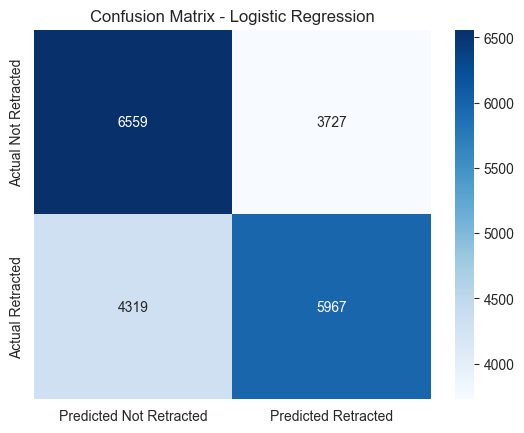

In [22]:
# TRAIN AND EVALUATE BASELINE MODEL - LOGISTIC REGRESSION

# We define a full pipeline that first preprocesses the data, then fits the model.
# This is best practice to prevent data leakage from the test set.

# 1. Define the model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

# 2. Create the full pipeline
pipeline_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg_model)
])

# 3. Train the pipeline on the training data
print("Training Logistic Regression model")
pipeline_log_reg.fit(X_train, y_train)
print("✅ Training complete.")

# 4. Evaluate the model on the test data
print("Evaluating Logistic Regression performance")
y_pred = pipeline_log_reg.predict(X_test)
y_pred_proba = pipeline_log_reg.predict_proba(X_test)[:, 1]

# Print Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Not Retracted', 'Predicted Retracted'], 
            yticklabels=['Actual Not Retracted', 'Actual Retracted'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Training Random Forest model
✅ Training complete.
Evaluating Random Forest performance
Accuracy:  0.6700
Precision: 0.6872
Recall:    0.6241
F1-Score:  0.6542
ROC AUC:   0.7317


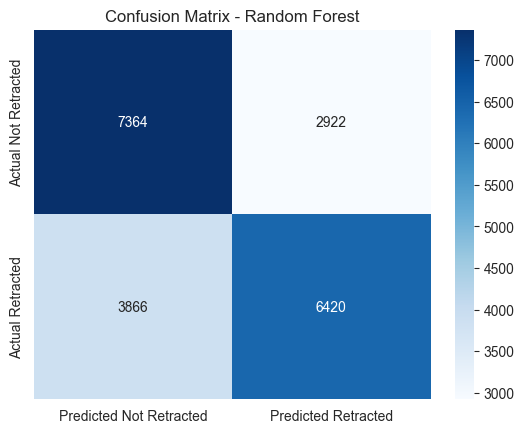

In [23]:
# TRAIN AND EVALUATE MODEL 2 - RANDOM FOREST CLASSIFIER

# We will now train a more powerful ensemble model to see if we can beat our baseline.

# 1. Define the model
# We'll start with some sensible default parameters.
# n_jobs=-1 will use all available CPU cores to speed up training.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Create the full pipeline
# We re-use the SAME preprocessor, which is very efficient.
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# 3. Train the pipeline on the training data
print("Training Random Forest model")
pipeline_rf.fit(X_train, y_train)
print("✅ Training complete.")

# 4. Evaluate the model on the test data
print("Evaluating Random Forest performance")
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# Print Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# --- Plot Confusion Matrix ---
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Retracted', 'Predicted Retracted'], 
            yticklabels=['Actual Not Retracted', 'Actual Retracted'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

Training XGBoost model
✅ Training complete.
Evaluating XGBoost performance
Accuracy:  0.6669
Precision: 0.6751
Recall:    0.6437
F1-Score:  0.6590
ROC AUC:   0.7361


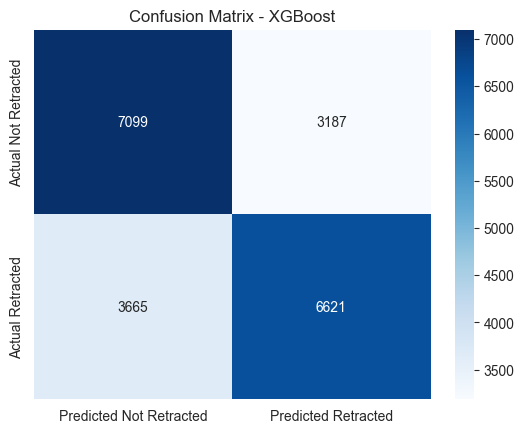

In [25]:
# TRAIN AND EVALUATE MODEL 3 - XGBOOST CLASSIFIER

# XGBoost is often a top performer on tabular data. Let's see how it does.

# 1. Define the model
# We set use_label_encoder=False to avoid a deprecation warning.
# objective='binary:logistic' tells XGBoost this is a binary classification problem.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# 2. Create the full pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# 3. Train the pipeline on the training data
print("Training XGBoost model")
pipeline_xgb.fit(X_train, y_train)
print("✅ Training complete.")

# 4. Evaluate the model on the test data
print("Evaluating XGBoost performance")
y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

# Print Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Plot Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Retracted', 'Predicted Retracted'], 
            yticklabels=['Actual Not Retracted', 'Actual Retracted'])
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [ ]:
# HYPERPARAMETER TUNING FOR XGBOOST MODEL

# 1. Define the model pipeline (we need to define it again to put it inside the search)
# We create a fresh pipeline object for the tuning process.
xgb_for_tuning = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

pipeline_for_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_for_tuning)
])


# 2. Define the hyperparameter search space (the 'grid')
# We define a range or list of values for the most important XGBoost parameters.
# The keys must match the pipeline's step names: 'classifier__<parameter_name>'

param_distributions = {
    'classifier__n_estimators': randint(100, 500), # Number of trees
    'classifier__max_depth': randint(3, 10), # Max depth of a tree
    'classifier__learning_rate': uniform(0.01, 0.3), # Step size shrinkage
    'classifier__subsample': uniform(0.6, 0.4), # Subsample ratio of the training instance
    'classifier__colsample_bytree': uniform(0.6, 0.4) # Subsample ratio of columns when constructing each tree
}


# 3. Set up RandomizedSearchCV
# n_iter: number of random combinations to try. 50 is a good starting point.
# cv: number of cross-validation folds. 5 is standard.
# scoring: the metric to optimize for. 'roc_auc' is perfect for our problem.
# n_jobs: use all available CPU cores.
# random_state: for reproducibility of the random search.

random_search = RandomizedSearchCV(
    pipeline_for_tuning,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1 # This will show progress updates
)

# 4. Fit the model
# This will start the search process and can take a considerable amount of time.
print("Starting Hyperparameter Tuning for XGBoost (Randomized Search)")
print("This may take a while")

random_search.fit(X_train, y_train)

print("\n✅ Tuning complete!")

# 5. Print the best parameters and best score found during the search
print("\nBest parameters found:")
print(random_search.best_params_)

print(f"\nBest ROC AUC score during cross-validation: {random_search.best_score_:.4f}")

Starting Hyperparameter Tuning for XGBoost (Randomized Search)
This may take a while
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Tuning complete!

Best parameters found:
{'classifier__colsample_bytree': 0.7797802696552814, 'classifier__learning_rate': 0.038623034947123394, 'classifier__max_depth': 9, 'classifier__n_estimators': 161, 'classifier__subsample': 0.7300733288106989}

Best ROC AUC score during cross-validation: 0.7403


Evaluating the BEST XGBoost model on the unseen test set
Accuracy:  0.6697
Precision: 0.6854
Recall:    0.6276
F1-Score:  0.6552
ROC AUC:   0.7414


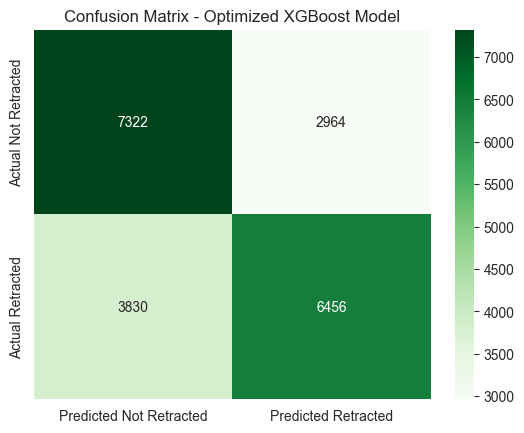

ROC Curve Comparison


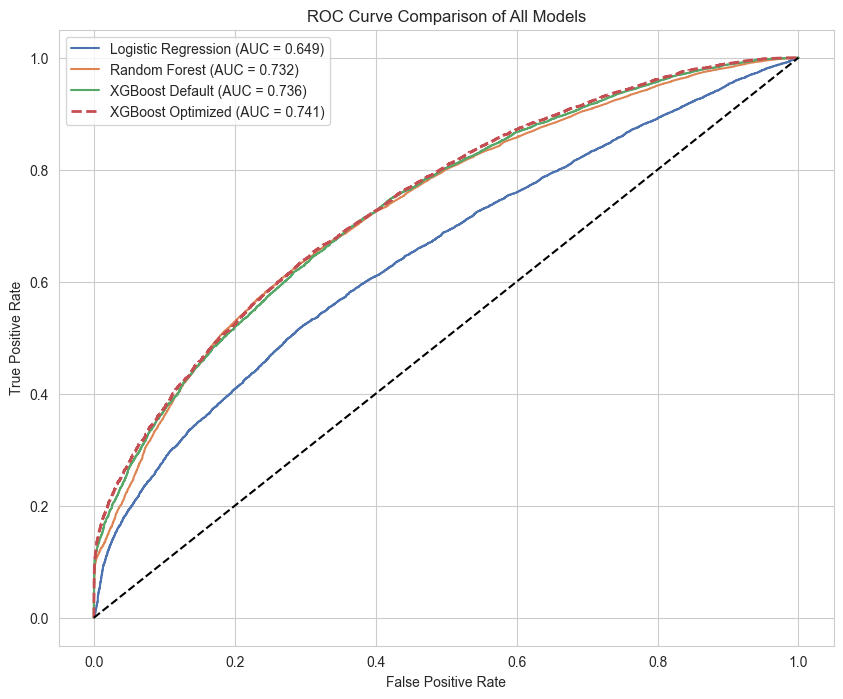

In [ ]:
# FINAL EVALUATION OF THE OPTIMIZED MODEL

print("Evaluating the BEST XGBoost model on the unseen test set")

# The 'random_search' object automatically refits the best model on the entire training set,
# so we can use it directly for prediction.
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Print Final Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba_best):.4f}")

# Plot Final Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', # Using a different color to distinguish
            xticklabels=['Predicted Not Retracted', 'Predicted Retracted'], 
            yticklabels=['Actual Not Retracted', 'Actual Retracted'])
plt.title('Confusion Matrix - Optimized XGBoost Model')
plt.show()

# Plot ROC Curve Compariso
print("ROC Curve Comparison")

# Calculate ROC curves
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, pipeline_log_reg.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, pipeline_rf.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pipeline_xgb.predict_proba(X_test)[:,1])
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, pipeline_log_reg.predict_proba(X_test)[:,1]):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:,1]):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost Default (AUC = {roc_auc_score(y_test, pipeline_xgb.predict_proba(X_test)[:,1]):.3f})')
plt.plot(fpr_best, tpr_best, label=f'XGBoost Optimized (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of All Models')
plt.legend()
plt.show()

In [33]:
# SAVE THE FINAL MODEL PIPELINE

# The best model is stored in the 'best_estimator_' attribute of our search object
final_model_pipeline = random_search.best_estimator_

# Define the file path for the saved model
model_filepath = '../models/paperlens_xgb_pipeline.pkl'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_filepath), exist_ok=True)

# Save the entire pipeline object to a file using pickle
with open(model_filepath, 'wb') as f:
    pickle.dump(final_model_pipeline, f)

print(f"✅ Final model pipeline has been saved successfully to: {model_filepath}")
print("This file contains both the preprocessor and the trained XGBoost model.")

✅ Final model pipeline has been saved successfully to: ../models/paperlens_xgb_pipeline.pkl
This file contains both the preprocessor and the trained XGBoost model.


<h2 style="color: 	#365F93;"><strong>8. Conclusions</strong></h2>

- Most relevant variables
- Potential future improvements

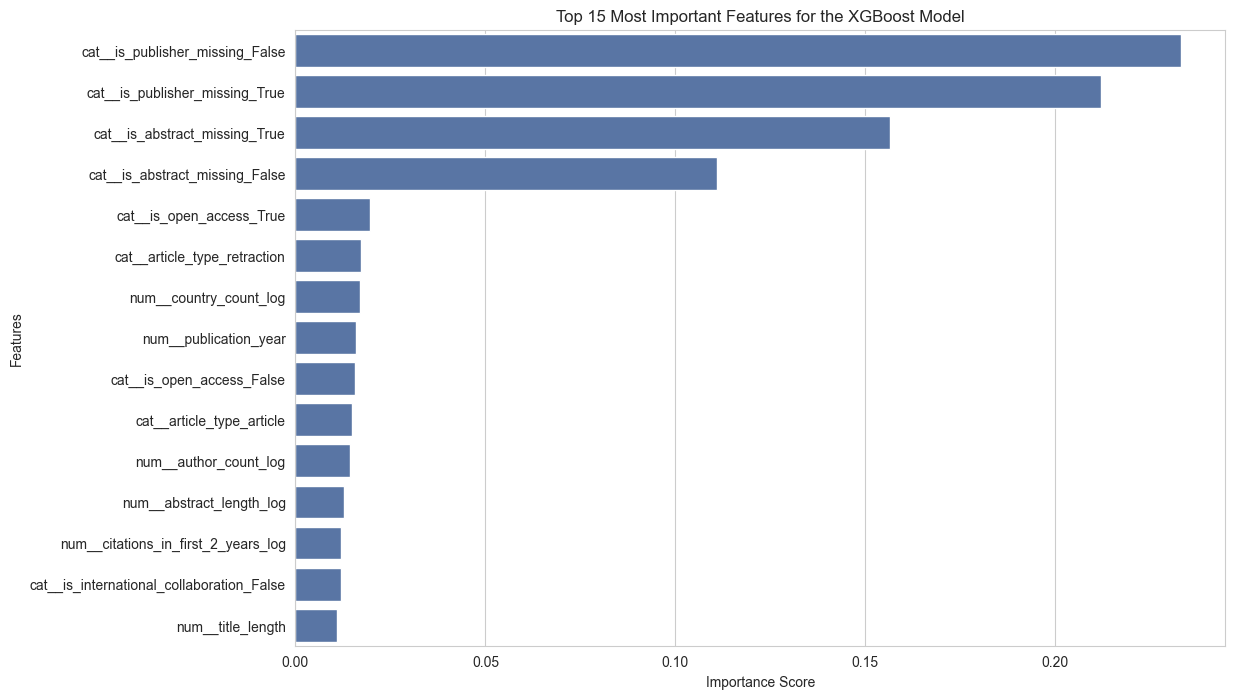

Top 10 Feature Importances
cat__is_publisher_missing_False    0.233097
cat__is_publisher_missing_True     0.212063
cat__is_abstract_missing_True      0.156492
cat__is_abstract_missing_False     0.111071
cat__is_open_access_True           0.019657
cat__article_type_retraction       0.017302
num__country_count_log             0.016887
num__publication_year              0.016053
cat__is_open_access_False          0.015761
cat__article_type_article          0.014923
dtype: float32


In [34]:
# FEATURE IMPORTANCE ANALYSIS

# The trained model is the second step ('classifier') in our final pipeline
xgb_classifier = final_model_pipeline.named_steps['classifier']

# The preprocessor is the first step
preprocessor = final_model_pipeline.named_steps['preprocessor']

# We need to get the final feature names AFTER one-hot encoding
# The preprocessor's 'get_feature_names_out' method is perfect for this
final_feature_names = preprocessor.get_feature_names_out()

# Create a pandas Series with the feature importances
importances = pd.Series(
    xgb_classifier.feature_importances_, 
    index=final_feature_names
).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title('Top 15 Most Important Features for the XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print("Top 10 Feature Importances")
print(importances.head(10))

### **Final Conclusions and Next Steps**

This project set out to build a machine learning model capable of predicting the retraction risk of a scientific paper based on its metadata. After a rigorous process of data acquisition, cleaning, case-control matching, exploratory analysis, and model optimization, we have successfully developed a robust predictive tool.

#### **Model Performance Summary**

Our final, optimized XGBoost model achieved a strong and meaningful performance on the hold-out test set, demonstrating its ability to generalize to unseen data:

-   **ROC AUC: 0.7414**
-   **Accuracy:** 66.97%
-   **Precision:** 68.54%
-   **Recall:** 62.76%
-   **F1-Score:** 65.52%

The ROC AUC score of 0.7414 represents a **significant 9.2-point improvement** over our baseline Logistic Regression model (0.649). This confirms that the features we engineered contain a clear predictive signal and that a more complex model like XGBoost is well-suited to this problem. The model now possesses a decent and reliable capacity to distinguish between high-risk and low-risk publications.

#### **Key Predictive Features: The Power of Metadata Integrity**

The feature importance analysis provided the most compelling insight of this project. It revealed that the model's decisions are overwhelmingly driven not by content metrics, but by the **integrity and completeness of a paper's metadata**.

The top predictive features were:
1.  **`is_publisher_missing` (True/False):** This single feature accounted for a massive **~44.5%** of the model's decision-making power. The absence of an identifiable publisher is the strongest red flag for retraction risk.
2.  **`is_abstract_missing` (True/False):** The second most powerful signal, contributing **~27%** to the model's predictions. Papers without a proper abstract are significantly more likely to be retracted.
3.  **Secondary Features:** Variables like `is_open_access`, `publication_year`, and our log-transformed `country_count_log` also contributed, but to a much lesser extent.

This perfectly validates our initial EDA hypotheses. The model has learned that the context and "professionalism" of a paper's registration are far more telling than शुरुआती content metrics like citation counts, which had lower importance.

#### **Model Limitations and Areas for Improvement**

Despite its success, it is crucial to acknowledge the model's current limitations:
-   **Recall Score:** A recall of **~63%** is a solid start, but it means the model still fails to identify over a third of all retracted papers. For a real-world risk detection tool, minimizing these "false negatives" is a primary goal for future iterations.
-   **Semantic Blindness:** The model currently does not analyze the semantic content of the paper's title or abstract. It understands their length, but not their meaning. This is likely the single largest untapped source of predictive information.

#### **Next Steps for Project "PaperLens"**

This analysis concludes the modeling phase and sets a clear path forward for developing a functional product.

1.  **Deployment (`app.py`):** The primary next step is to use the saved `paperlens_xgb_pipeline.pkl` model to build an interactive web application with Streamlit or in other place. This app will serve as our MVP, allowing users to input a paper's DOI and receive a real-time retraction risk score based on our trained model.
2.  **Future Model Enhancement:**
    -   **NLP Embeddings:** The most promising avenue for a significant performance boost is to incorporate text embeddings from abstracts and titles using libraries like `sentence-transformers`. This would allow the model to learn from the *meaning* of the paper's content.
    -   **Threshold Tuning:** For the deployed application, we will experiment with adjusting the model's decision threshold (default is 0.5). By lowering it, we can intentionally increase the model's **Recall** to catch more high-risk papers, even if it means accepting a slightly lower Precision.
    -   **Advanced Feature Engineering:** Implement target encoding for high-cardinality features like `publisher` and `country` to extract more predictive power without creating thousands of columns.
    -   **Explore Stacking:** Combine the predictions of our XGBoost, Random Forest, and other models into a "stacked" ensemble to potentially gain a final, marginal improvement in performance.

<details>
<summary><strong>💡 Brainstorming Future Improvements & Advanced Techniques (English)</strong></summary>

<br>

Now that I've completed the standard modeling cycle, I'm thinking like a Data Scientist and asking myself: "How can I push this model's ROC AUC score from 0.74 to over 0.80, or even higher?"

Here's a list of more advanced techniques I'm considering, from the most accessible to the most complex, which could give my model a significant quality boost.

---

#### **1. Advanced Feature Engineering (Impact: High, Difficulty: Medium)**

This is where the biggest gains are usually found. My model is only as good as the features I give it.

*   **Create Features from `publisher` and `country`:** Instead of discarding `publisher` and `first_author_country` due to their high cardinality, I can extract "meta-features" from them.
    1.  **Publisher "Frequency":** I could calculate how often each publisher appears in the dataset. Very rare publishers might be more suspicious.
    2.  **Publisher "Risk Rate" (Target Encoding):** This is a powerful one. For each publisher, I can calculate its average retraction rate within the *training* set. Then, I can use this rate as a new feature. I have to be very careful to do this using only the `X_train` data to avoid data leakage.
    3.  **Repeat the same for `first_author_country`**.

*   **Temporal Analysis:**
    1.  **"Article Age at Retraction":** For the retracted cases, I could calculate `retraction_date - publication_date`. Do fraudulent articles get discovered quickly? This wouldn't be a predictive feature, but a very interesting extra analysis for the EDA.
    2.  **"Velocity Features":** How fast do citations grow? I could calculate `citations_in_first_YEAR` and `citations_in_second_YEAR` separately. An anomalous spike in the first year could be a signal.

---

#### **2. The Secret Weapon: Text Embeddings (NLP) (Impact: Potentially Huge, Difficulty: Medium-High)**

So far, I've ignored the actual content of the `title` and `abstract`. There's a gold mine of information there.

*   **The Idea:** Convert the text of each abstract (or the concatenation of title + abstract) into a numerical vector (an "embedding") that captures its semantic meaning.
*   **How I'd do it:**
    1.  Use a library like `sentence-transformers` (which I've already installed).
    2.  Choose a powerful yet lightweight pre-trained model like `'all-MiniLM-L6-v2'`.
    3.  Pass all my abstracts through this model. It would return a vector of, for example, 384 numbers for each abstract.
*   **Integration:**
    1.  These 384 numbers are 384 new numerical features.
    2.  I could **concatenate** these new embedding features with my current tabular features (`X_final_features`) to create a super-enriched feature matrix.
    3.  Then, I would retrain my XGBoost model on this new dataset. Tree-based models like XGBoost are surprisingly good at handling a mix of tabular and embedding data.

**Why is this so powerful?** The model could learn subtle semantic patterns: "papers that use overly grand and vague language in their abstracts tend to be riskier" or "those that mention specific statistical methods in detail are more reliable."

---

#### **3. Stacking and Advanced Ensembling (Impact: Medium, Difficulty: Medium)**

*   **The Idea:** Instead of choosing a single "champion" model, why not combine the strengths of several? A "Stacking Classifier" uses the predictions of several base models (e.g., Logistic Regression, Random Forest, and maybe an SVM) as input features for a final "meta-model" (often another XGBoost or Logistic Regression) that learns how to weigh their opinions.
*   **How I'd do it:** Scikit-learn has a `StackingClassifier` class that makes this process much easier.

---

#### **4. Considering an Alternative Control Dataset**

*   **The Idea:** My matching by `source_id` is excellent. But as an experiment, I could test my professor's hypothesis: what would happen if the control group were **completely random**?
*   **How I'd do it:** Create a new control group of ~55k articles selected totally at random (only with the condition `is_retracted:false` and within a similar year range). Then, I'd train the same XGBoost pipeline on this new dataset.
*   **Comparative Analysis:** I would compare the `ROC AUC` and `feature_importances_` of the two models.
    *   **My Prediction:** The model with the random control group would likely have a higher `ROC AUC`, but its `feature_importances_` would show that it relies heavily on `publisher` and `country`, learning obvious lessons. The model with the matched control would have a slightly lower `ROC AUC`, but its `feature_importances_` would reveal the subtle and truly interesting signals. **Making this comparison in my final project would be top-level work.**

Of all these options, if I had to choose one to get the biggest impact for a reasonable amount of effort, it would undoubtedly be **number 2: using Text Embeddings**. It's the natural next step for a problem like this and has the potential to drastically improve the model.

</details>

<details>
<summary><strong>💡 Brainstorming sobre Mejoras Futuras y Técnicas Avanzadas (Español)</strong></summary>

<br>

Ahora que he completado el ciclo "estándar" de modelado, voy a pensar como un Data Scientist con más experiencia y a preguntarme: "¿Cómo puedo llevar este modelo de un ROC AUC de 0.74 a más de 0.80, o incluso más?"

Aquí tengo una lista de técnicas más avanzadas, desde las más accesibles a las más complejas, que podrían darle un salto de calidad significativo a mi modelo.

---

#### **1. Ingeniería de Características Avanzada (Impacto: Alto, Dificultad: Media)**

Aquí es donde suelen estar las mayores ganancias. Mi modelo es tan bueno como las features que le proporciono.

*   **Crear Features a partir de `publisher` y `country`:** En lugar de descartar `publisher` y `first_author_country` por su alta cardinalidad, puedo extraer "meta-features" de ellos.
    1.  **"Frecuencia" del Publisher:** Podría calcular la frecuencia con la que aparece cada publisher en el dataset. Los publishers muy raros podrían ser más sospechosos.
    2.  **"Tasa de Riesgo" del Publisher (Target Encoding):** ¡Esta es muy potente! Para cada publisher, puedo calcular su tasa de retractación promedio en el conjunto de *entrenamiento*. Luego, puedo usar esta tasa como una nueva feature. Tengo que hacerlo con mucho cuidado (usando solo los datos de `X_train`) para no causar "data leakage".
    3.  **Repetir lo mismo para `first_author_country`**.

*   **Análisis Temporal:**
    1.  **"Antigüedad del Artículo en el Momento de la Retractación":** Para los casos retractados, podría calcular `retraction_date - publication_date`. ¿Los artículos fraudulentos se descubren rápido? Esta no sería una feature predictiva, sino un análisis extra muy interesante para el EDA.
    2.  **"Features de Velocidad":** ¿Cómo de rápido crecen las citas? Podría calcular `citations_in_first_YEAR` y `citations_in_second_YEAR` por separado. Un pico anómalo en el primer año podría ser una señal.

---

#### **2. El Arma Secreta: Embeddings de Texto (NLP) (Impacto: Potencialmente Enorme, Dificultad: Media-Alta)**

Hasta ahora, he ignorado el contenido real del `title` y el `abstract`. ¡Ahí hay una mina de oro!

*   **La Idea:** Convertir el texto de cada abstract (o la concatenación de título + abstract) en un vector numérico (un "embedding") que capture su significado semántico.
*   **Cómo lo haría:**
    1.  Usaría una librería como `sentence-transformers` (que ya he instalado).
    2.  Elegiría un modelo pre-entrenado potente y ligero como `'all-MiniLM-L6-v2'`.
    3.  Pasaría todos mis abstracts por este modelo. Me devolvería un vector de, por ejemplo, 384 números para cada abstract.
*   **Integración:**
    1.  Estos 384 números son 384 nuevas features numéricas.
    2.  Podría **concatenar** estas nuevas features de embedding con mis features tabulares actuales (`X_final_features`) para crear una matriz de características súper enriquecida.
    3.  Después, volvería a entrenar mi XGBoost con este nuevo set de datos. Los modelos de árboles como XGBoost son sorprendentemente buenos manejando la mezcla de datos tabulares y embeddings.

**¿Por qué es tan potente?** El modelo podría aprender patrones semánticos sutiles: "los artículos que usan un lenguaje demasiado grandilocuente y vago en sus abstracts tienden a ser más riesgosos" o "los que mencionan métodos estadísticos específicos de forma detallada son más fiables".

---

#### **3. Stacking y Ensamblajes Avanzados (Impacto: Medio, Dificultad: Media)**

*   **La Idea:** En lugar de elegir un solo modelo "campeón", ¿por qué no combinar las fortalezas de varios? Un "Stacking Classifier" usa las predicciones de varios modelos base (ej. Regresión Logística, Random Forest, y quizás un SVM) como features de entrada para un "meta-modelo" final (a menudo, otro XGBoost o Regresión Logística) que aprende a ponderar sus opiniones.
*   **Cómo lo haría:** Scikit-learn tiene una clase `StackingClassifier` que facilita mucho este proceso.

---

#### **4. Considerar un Dataset de Control Alternativo**

*   **La Idea:** Mi matching por `source_id` es excelente. Pero como experimento, podría probar la hipótesis de mi profesor: ¿qué pasaría si el grupo de control fuera **completamente aleatorio**?
*   **Cómo lo haría:** Crearía un nuevo grupo de control de ~55k artículos seleccionados totalmente al azar (solo con la condición `is_retracted:false` y dentro de un rango de años similar). Después, entrenaría el mismo pipeline de XGBoost en este nuevo dataset.
*   **Análisis Comparativo:** Compararía el `ROC AUC` y las `feature_importances_` de los dos modelos.
    *   **Mi Predicción:** El modelo con el control aleatorio probablemente tendría un `ROC AUC` más alto, pero su `feature_importances_` mostraría que se apoya masivamente en `publisher` y `country`, aprendiendo lecciones obvias. El modelo con el control "matcheado" tendrá un `ROC AUC` ligeramente menor, pero sus `feature_importances_` revelarán las señales sutiles y verdaderamente interesantes. **Hacer esta comparación en mi proyecto final sería de un nivel altísimo.**

De todas estas opciones, si tuviera que elegir una para conseguir el mayor impacto con un esfuerzo razonable, sería sin duda la **número 2: usar Embeddings de Texto**. Es el siguiente paso natural para un problema como este y tiene el potencial de mejorar drásticamente el modelo.

</details>